In [1]:
LEVEL = -1

ID_FILTER = '';   #  ['HOBBIES', 'HOUSEHOLD', 'FOODS', ]

IMPORT = True 
MAX_LEVEL = 9

In [2]:
QUANTILES = [0.005, 0.025, 0.165,  ] #   0.5,  0.75, 0.835, 0.975, 0.995]
QUANTILES = [0.25,  0.5, ]
# QUANTILES = [0.75, 0.835,  0.975, 0.995]
# QUANTILES = [0.5, ]
QUANTILES = [0.75, 0.835, ] 
QUANTILES = [0.975, 0.995]

In [3]:
P_DICT = \
    {1: (0.3, 0.7),   2: (0.1, 0.7),  3: (0.1, 0.5), 
     4: (0.3, 0.5),   5: (0.15, 1),    6: (0.2, 0.5),
     7: (0.1, 1),     8: (0.2, 0.5),    9: (0.1, 0.5),
    10: (0.05, 0.5), 11: (0.04, 1),  
    'HOBBIES': (0.12, 2), 'HOUSEHOLD': (0.065, 2), 'FOODS': (0.03, 0.5)}



In [4]:

BAGS = 1
N_JOBS = -1


SS_PWR = 0.6
BAGS_PWR = 0


In [5]:
FEATURE_DROPS = ['item_id', '_abs_diff', 'squared_diff' ]\
                +    ['336', '300d'] 

In [6]:
# run-time parameters
CACHED_FEATURES = False
CACHE_FEATURES = False


In [7]:
PREDICT_ALL = False
PREDICT_AND_SAVE = True
KEEP_PREDICTIONS = True

In [8]:
TIME_SEED = True

In [9]:
PRICE_FEATURES = False

### Load Packages and Settings

In [10]:
import numpy as np  
import pandas as pd 

In [11]:
import psutil


In [12]:
import pickle

In [13]:
from collections import Counter
import datetime as datetime
from scipy.stats.mstats import gmean
import random

In [14]:
import gc
import gzip
import bz2

In [15]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (17,5.5)
rcParams['figure.max_open_warning'] = 0
# %config InlineBackend.figure_format='retina'


In [16]:
import seaborn as sns


In [17]:
pd.options.display.max_rows = 150



In [18]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


In [19]:
start = datetime.datetime.now()



In [20]:
if TIME_SEED:
    np.random.seed(datetime.datetime.now().microsecond)

In [21]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def memCheck():
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                             key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [22]:
def ramCheck():
    print("{:.1f} GB used".format(psutil.virtual_memory().used/1e9 - 0.7))


In [23]:
path = '/kaggle/input/m5-forecasting-uncertainty/'

In [24]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv
/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv
/kaggle/input/m5-forecasting-uncertainty/calendar.csv
/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_evaluation.csv
/kaggle/input/m5clfs/lvl_5_high.pkl
/kaggle/input/m5clfs/foods_midhigh.pkl
/kaggle/input/m5clfs/lvl_3_mid.pkl
/kaggle/input/m5clfs/foods_high.pkl
/kaggle/input/m5clfs/hobbies_mid.pkl
/kaggle/input/m5clfs/lvl_7_high.pkl
/kaggle/input/m5clfs/lvl_8_high.pkl
/kaggle/input/m5clfs/lvl_5_low.pkl
/kaggle/input/m5clfs/foods_low.pkl
/kaggle/input/m5clfs/lvl_11_midhigh.pkl
/kaggle/input/m5clfs/lvl_4_mid.pkl
/kaggle/input/m5clfs/hobbies_low.pkl
/kaggle/input/m5clfs/lvl_1_low.pkl
/kaggle/input/m5clfs/household_low.pkl
/kaggle/input/m5clfs/lvl_3_high.pkl
/kaggle/input/m5clfs/hobbies_high.pkl
/kaggle/input/m5clfs/lvl_1_mid.pkl
/kaggle/input/m5clfs/lvl_9_low.pkl
/kaggle/input/m5clfs/lvl_7_low.pkl


In [25]:
ramCheck()


0.3 GB used


### Load and Aggregate Training Data

In [26]:
LEVELS = [(12, ['item_id', 'store_id']),
          (11, ['state_id', 'item_id']),
          (10, ['item_id']),
          (9, ['store_id', 'dept_id']),
          (8, ['store_id', 'cat_id']),
          (7, ['state_id', 'dept_id']),
          (6, ['state_id', 'cat_id']),
          (5, ['dept_id']),
          (4, ['cat_id']),
          (3, ['store_id']),
          (2, ['state_id']),
          (1, []) ]

DOWNSTREAM = {'item_id': ['dept_id', 'cat_id'],
              'dept_id': ['cat_id'],
              'store_id': ['state_id']}

In [27]:
def aggTrain(train):
    tcd = dict([(col, 'first') for col in train.columns[1:6]])
    tcd.update( dict([(col, 'sum') for col in train.columns[6:]]))

    tadds =[]; tadd_levels= [ [12 for i in range(0, len(train))] ] 
    for idx, lvl in enumerate(LEVELS[1:]):
        level = lvl[0]
        lvls = lvl[1]

        if len(lvls) is 0:  # group all if no list provided
            lvls = [1 for i in range(0, len(train))]

        tadd = train.groupby(lvls).agg(tcd)

        # name it
        if len(lvls) == 2:
            tadd.index = ['_'.join(map(str,i)) for i in tadd.index.tolist()]
        elif len(lvls) == 1:
            tadd.index = tadd.index + '_X'
        else:
            tadd.index = ['Total_X']
        tadd.index.name = 'id'

        # fill in categorical features
        tadd.reset_index(inplace=True)
        for col in [c for c in train.columns[1:6] if c not in lvls and not  
                            any(c in z for z in[DOWNSTREAM[lvl] for lvl in lvls if lvl in DOWNSTREAM])]:
            tadd[col] = 'All'
        tadds.append(tadd)

        #levels
        tadd_levels.append([level for i in range(0, len(tadd))])

    train = pd.concat((train,*tadds), sort=False, ignore_index=True); del tadds, tadd
    levels = pd.Series(data = [x for sub_list in tadd_levels for x in sub_list], index = train.index); del tadd_levels
    for col in train.columns[1:6]:
        train[col] = train[col].astype('category')
        
    return train, levels

In [28]:
def loadTrain():
    train_cols =  pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', nrows=1)

    c_dict = {}
    for col in [c for c in train_cols if 'd_' in c]:
        c_dict[col] = np.float32

    train = pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', dtype=c_dict)#.astype(np.int16, errors='ignore')

    train.id = train.id.str.split('_').str[:-1].str.join('_')
    
    train.sort_values('id', inplace=True)
    
    return train.reset_index(drop=True)

In [29]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    prices.sort_values('id', inplace=True)
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    return price_pivot

In [30]:
def getCal():
    return pd.read_csv(path+ '/' + 'calendar.csv').set_index('d')

In [31]:
cal = getCal()
cal.date = pd.to_datetime(cal.date)

day_to_cal_index = dict([(col, idx) for idx, col in enumerate(cal.index)])
cal_index_to_day = dict([(idx, col) for idx, col in enumerate(cal.index)])

cal_index_to_wm_yr_wk = dict([(idx, col) for idx, col in enumerate(cal.wm_yr_wk)])
day_to_wm_yr_wk = dict([(idx, col) for idx, col in cal.wm_yr_wk.iteritems()])

In [32]:
# Load
train = loadTrain()
price_pivot = getPricePivot()

daily_sales = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:] * price_pivot.loc[train.columns[6:].fillna(0)\
                                                                .map(day_to_wm_yr_wk)].transpose().values ), 
                            axis = 'columns')

In [33]:
# Aggregate
train, levels = aggTrain(train)
id_to_level = dict(zip(train.id, levels))
level_to_ids = dict([(level[0], list(train.id[levels == level[0]])) for idx, level in enumerate(LEVELS)])

daily_sales = aggTrain(daily_sales)[0]


In [34]:
level_multiplier = dict([ (c, (levels==c).sum() / (levels==12).sum()) for c in range(1,13)])

In [35]:
# Rescale by number of series at each level
train = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')

daily_sales = pd.concat((daily_sales.iloc[:, :6], 
                        daily_sales.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')


In [36]:
def loadSampleSub():
    return pd.read_csv(path+ '/' + 'sample_submission.csv').astype(np.int8, errors = 'ignore')

In [37]:
sample_sub = loadSampleSub()

In [38]:
assert set(train.id) == set(sample_sub.id.str.split('_').str[:-2].str.join('_'))

In [39]:
print(len(train))

42840


In [40]:
ramCheck()

1.8 GB used


In [41]:
memCheck()

                         train: 320.8 MiB
                   daily_sales: 320.8 MiB
                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                   id_to_level:  1.3 MiB
                           cal: 624.0 KiB
                        levels: 334.8 KiB
              day_to_cal_index: 72.1 KiB
              cal_index_to_day: 72.1 KiB
         cal_index_to_wm_yr_wk: 72.1 KiB


In [42]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  67 s


In [43]:
train_filter = (   
               ( ( MAX_LEVEL is not None )   & (levels <= MAX_LEVEL) )  | 
              ((train.cat_id == ID_FILTER) & (levels == LEVEL))  |
                ( (levels < 12) & (levels == LEVEL) )
                 )
train = train[train_filter].reset_index(drop=True)
daily_sales = daily_sales[train_filter].reset_index(drop=True)
levels = levels[train_filter].reset_index(drop=True).astype(np.int8)

In [44]:
train.head()

id item_id    dept_id   cat_id store_id state_id       d_1  \
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA  0.681863   
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA  1.547393   
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA  5.206953   
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA  1.212201   
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA  0.064283   

        d_2       d_3       d_4  ...    d_1932    d_1933    d_1934    d_1935  \
0  0.652017  0.491309  0.401771  ...  0.945884  0.998688  0.952771  0.635946   
1  1.503772  0.909151  1.092817  ...  1.251230  1.402755  1.793047  1.274188   
2  5.046245  3.209577  3.689406  ...  5.528370  6.887504  8.083634  5.431945   
3  1.122663  0.938996  0.879305  ...  1.253526  1.680551  1.448672  0.893080   
4  0.020663  0.013775  0.020663  ...  0.096425  0.169892  0.128567  0.064283   

     d_1936    d_1937    d_1938    d_1939    d_1940    d_1941  
0  0.693342  0.911446  0.757625  0.711709  0.980321  0.766809  
1  1.092817  0.980321  0.943588  0.996392  1.439488  1.650705  
2  4.628403  4.573303  4.851099  5.163332  6.265333  7.516563  
3  0.796655  0.810430  0.812725  1.134142  1.506068  1.349951  
4  0.105608  0.064283  0.119383  0.103313  0.144638  0.133158  

[5 rows x 1947 columns]

In [45]:
print(len(train))

154


In [46]:
train_head = train.iloc[:, :6]  

In [47]:
train_head.head()

id item_id    dept_id   cat_id store_id state_id
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA

In [48]:
ramCheck()

1.1 GB used


In [49]:
# day of week; day of month; day of year;
# holiday days_til for each holiday (fade to 0 by 10 days away);
# SNAP for state_id; SNAP_lag_1; SNAP_lag_2; ewm_SNAP; days_since_last_snap; days_til_next_snap;
# EWM of product over 2, 5, 10, 20, etc. days
# EWM of sales on all snap days; EWM sales on snap gap days; EWM sales on away-snap period;
# EWM sales on that day of week
# EWM sales on snap first_day, etc.
# EWMS of ALL SALES--to spot recent trends
# some types of wavelets of overall sales, category sales, store sales, id sales, etc.
# EWM sales for each department etc.;

# various features on prior prices... EMW X-overs on this price mainly; 
#          price shock: EMA-xover all prices
#             do these with and without fill-drops back to full;
#    num_price_drops etc.

In [50]:
# DICEY:
# PCAs or SAEs of sales, RNN to predict each component etc.
# some form of clustering model run periodically *qrtly* to group items into clusters
# then inlcude EWMS and EWM x-overs on that cluster specifically; day of week clusters etc.


# Basic Models:
# LightGBM, for all window types 
# Seq2Seq RNN given all prior sequences (store, cat, product, SNAP y/n, and other info)
# 

# Other:
# some use of wavelets;
# historical sales at this time of year versus preceding sales EMWs 
# 

In [51]:
# how to describe a product:
# dept_id (categorical)
# percent Monday vs. other days; x7 (very long-run EWM, pure ratio)
# SNAP vs. normal sales, very long EWM
# CA %, TX %, WI % for item
# State_X vs. entire state for item; (multiple windows)

# state (categorical)
# store_ID (categorical)

# itemID as continuous:  X.Y;


## highly optional - item_id

In [52]:
# do some item early month late month skew, where weight 0...1 and 1....0 each day of month 

In [53]:
# most item EWMs should be done on ITEM+STORE  ITEM+STATE  ITEM


In [54]:
# replace leading zeros with nan
train['d_1'].replace(0, np.nan, inplace=True)

In [55]:
# replace leading zeros with NA
for i in range(train.columns.get_loc('d_1') + 1, train.shape[1]):
#     if i%300 == 0:
#         print(i)
#     print(train.loc[(train.iloc[:,i]==0) & (train.iloc[:,i-1].isnull()), train.columns[i]])
    train.loc[:, train.columns[i]].where( ~ ((train.iloc[:,i]==0) & (train.iloc[:,i-1].isnull())),
                                         np.nan, inplace=True)

In [56]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  70 s


In [57]:
train.head(5)

id item_id    dept_id   cat_id store_id state_id       d_1  \
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA  0.681863   
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA  1.547393   
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA  5.206953   
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA  1.212201   
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA  0.064283   

        d_2       d_3       d_4  ...    d_1932    d_1933    d_1934    d_1935  \
0  0.652017  0.491309  0.401771  ...  0.945884  0.998688  0.952771  0.635946   
1  1.503772  0.909151  1.092817  ...  1.251230  1.402755  1.793047  1.274188   
2  5.046245  3.209577  3.689406  ...  5.528370  6.887504  8.083634  5.431945   
3  1.122663  0.938996  0.879305  ...  1.253526  1.680551  1.448672  0.893080   
4  0.020663  0.013775  0.020663  ...  0.096425  0.169892  0.128567  0.064283   

     d_1936    d_1937    d_1938    d_1939    d_1940    d_1941  
0  0.693342  0.911446  0.757625  0.711709  0.980321  0.766809  
1  1.092817  0.980321  0.943588  0.996392  1.439488  1.650705  
2  4.628403  4.573303  4.851099  5.163332  6.265333  7.516563  
3  0.796655  0.810430  0.812725  1.134142  1.506068  1.349951  
4  0.105608  0.064283  0.119383  0.103313  0.144638  0.133158  

[5 rows x 1947 columns]

In [58]:
train_flipped = train.set_index('id', drop = True).iloc[:, 5:].transpose()

In [59]:
train_flipped.dtypes

id
CA_1_FOODS_1      float32
CA_1_FOODS_2      float32
CA_1_FOODS_3      float32
CA_1_HOBBIES_1    float32
CA_1_HOBBIES_2    float32
                   ...   
WI_3_X            float32
CA_X              float32
TX_X              float32
WI_X              float32
Total_X           float32
Length: 154, dtype: object

In [60]:
train_flipped.head()

id   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_1_HOBBIES_1  CA_1_HOBBIES_2  \
d_1      0.681863      1.547393      5.206953        1.212201        0.064283   
d_2      0.652017      1.503772      5.046245        1.122663        0.020663   
d_3      0.491309      0.909151      3.209577        0.938996        0.013775   
d_4      0.401771      1.092817      3.689406        0.879305        0.020663   
d_5      0.417842      0.812725      3.434569        0.603805        0.011479   

id   CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  CA_2_FOODS_1  CA_2_FOODS_2  \
d_1          0.828796          0.415546      0.932109      0.486717   
d_2          0.803542          0.390292      0.936701      0.521154   
d_3          0.640538          0.261725      0.546409      0.316825   
d_4          0.638242          0.282388      0.551000      0.399475   
d_5          0.447688          0.309938      0.505084      0.234175   

id   CA_2_FOODS_3  ...    TX_1_X    TX_2_X    TX_3_X    WI_1_X    WI_2_X  \
d_1      3.615940  ...  0.838308  1.263365  0.993768  0.886848  0.739915   
d_2      2.952443  ...  0.881273  1.291243  0.985897  0.719580  0.630371   
d_3      2.096097  ...  0.597573  0.895703  0.729747  0.512299  0.661856   
d_4      2.585110  ...  0.740571  0.968842  0.711381  0.410298  0.827156   
d_5      2.194818  ...  0.555592  0.817317  0.566087  0.000656  0.385372   

id     WI_3_X      CA_X      TX_X      WI_X   Total_X  
d_1  1.324369  1.396687  0.928632  0.885339  1.070220  
d_2  1.376845  1.358314  0.947524  0.818039  1.041292  
d_3  1.087898  0.994556  0.666907  0.678616  0.780026  
d_4  1.053132  1.086946  0.726238  0.687176  0.833454  
d_5  0.699246  0.976550  0.581699  0.325582  0.627944  

[5 rows x 154 columns]

In [61]:
train_flipped.max().sort_values(ascending=False)[::3000]

id
CA_3_FOODS_3    11.750082
dtype: float32

In [62]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                         train:  1.4 MiB
                   daily_sales:  1.4 MiB
                 train_flipped:  1.3 MiB
                   id_to_level:  1.3 MiB
                           cal: 624.0 KiB
                           _44: 328.7 KiB
                           _57: 328.7 KiB
                    train_head: 301.7 KiB


In [63]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  73 s


In [64]:
ramCheck()

1.1 GB used


### Item Features

In [65]:
# EWMS
# stdev
# stdev between stores
# corr between stores


# COME BACK LATER -- descale stores--and then calculate stdev between them as % of item sales

In [66]:
item_features = []

In [67]:
tff0 = train_flipped.fillna(0)

In [68]:
# # EWM THESE OVER INTERVALS  % NONZERO DAYS
# for window in [3, 7, 15, 30, 100, 300]:
#     item_features.append( ('pct_nonzero_days_{}d_ewm'.format(window),
#                      items_flipped.ne(0).ewm(span=window,
#                                        min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half) ) )


In [69]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  73 s


### Item-Store Features

In [70]:
features = []

In [71]:
if not CACHED_FEATURES:      # basic moving averages
    for window in [3, 7, 15, 30, 100]:
        features.append(('qs_{}d_ewm'.format(window), 
                         train_flipped.ewm(span=window, 
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))
#     features[-1][1].tail(5)
    
#     np.sum(train_flipped, axis=1)

In [72]:
store_avg_qs = train_flipped[train_flipped.columns[levels == 12]].transpose()\
            .groupby(train_head.iloc[(levels == 12).values].store_id.values).mean().fillna(1)
store_dept_avg_qs = train_flipped[train_flipped.columns[levels == 12]].transpose()\
            .groupby(  ( train_head.iloc[(levels == 12).values].store_id.astype(str) + '_'
                        + train_head.iloc[(levels == 12).values].dept_id.astype(str)).values
                    ).mean().fillna(1)

# basic moving averages, after removing any store trends
scaled_sales = train_flipped / (store_avg_qs.loc[train.store_id].transpose().values); 

if levels.min() == 12:
    # get overall store and store-dept sales matched to this id;
    store_avg_qs_matched = store_avg_qs.loc[train.store_id].transpose() 
    store_dept_avg_qs_matched = store_dept_avg_qs.loc[train.store_id.astype(str) + '_'
                                                  + train.dept_id.astype(str)
                                                ].transpose() 

    store_avg_qs_matched.columns = train_flipped.columns
    store_dept_avg_qs_matched.columns = train_flipped.columns

    ratio = (store_avg_qs_matched.rolling(28).mean() / store_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
    ratio = ratio.clip ( ratio.stack().quantile(0.01), ratio.stack().quantile(0.99))
#     features.append(('store_28d_58d_ratio',  ratio.astype(np.half)))

    ratio = (store_dept_avg_qs_matched.rolling(28).mean() / store_dept_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
    ratio = ratio.clip ( ratio.stack().quantile(0.003), ratio.stack().quantile(0.997))

#     features.append(('store_dept_28d_58d_ratio',  ratio.astype(np.half)))

    del store_avg_qs_matched, store_dept_avg_qs_matched, ratio

del store_avg_qs, store_dept_avg_qs,

In [73]:
# (store_avg_qs.transpose()['CA_3'].rolling(14).mean() / 1.5).plot();
# (  store_avg_qs.transpose()['CA_3'].rolling(28).mean() / store_avg_qs.transpose()['CA_3'].rolling(56).mean() 
#       + np.random.normal(0, 0.005, len(store_avg_qs.transpose() ) ) ).plot(legend=True);
# plt.axhline(1)

In [74]:
if not CACHED_FEATURES:
    for window in [3, 7, 15, 30, 100]:
        features.append(('qs_divbystore_{}d_ewm'.format(window), 
                         scaled_sales.ewm(span=window,
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))

In [75]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  73 s


In [76]:
# EWM THESE OVER INTERVALS  % NONZERO DAYS
if not CACHED_FEATURES:
    tff0ne0 = tff0.ne(0)
    for window in [7, 14, 28, 28*2, 28*4,  ]:  
        features.append( ('pct_nonzero_days_{}d'.format(window),
                         tff0ne0.rolling(window).mean().astype(np.half) ) )
    del tff0ne0

In [77]:
del tff0

In [78]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  73 s


In [79]:
arrs = [train_flipped, scaled_sales, ] # sales_over_all]
labels = ['qs', 'qs_divbystore', ] #'qs_divbyall']


In [80]:
if not CACHED_FEATURES:
    for lag in range(1, 10+1):
        features.append( ('qs_lag_{}d'.format(lag),
                              train_flipped.shift(lag).fillna(0).astype(np.half) ) )

In [81]:
# DIFF stats (mean abs diff, mean squraed diff)
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
#         abs_arr_diff = np.abs(arr.diff())
#         arr_diff_sq = np.power(abs_arr_diff,2)
        label = labels[idx]

        for window in [7, 14, 21, 28, 28*2, 28*4,  ]:  ## ** mean and median
            features.append( ('{}_mean_{}d'.format(label, window), 
                          arr.rolling(window).mean().astype(np.half) )  )

            features.append( ('{}_median_{}d'.format(label, window), 
                          arr.rolling(window).median().astype(np.half) )  )


            
            print('{}: {}'.format(label,window))

    #         if label == 'qs':
#             features.append( ( '{}_abs_diff_ewm_{}d'.format(label, window),
#                 abs_arr_diff.ewm(span = window,
#                                 min_periods = int(np.ceil(window ** 0.8))).mean().astype(np.half) ) )
    #         features[-1][1].tail(5)

    #         features.append( ('{}_abs_diff_over_mean_ewm_{}d'.format(label, window),
    #             ( abs_arr_diff.ewm(span = window,
    #                               min_periods = int(np.ceil(window ** 0.8)) ).mean()\
    #                      / arr.ewm(span = window,
    #                               min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half)  ) )
    #         features[-1][1].tail(5)

#             features.append( ('{}_squared_diff_ewm_{}d'.format(label, window),
#                 np.sqrt( arr_diff_sq.ewm(span = window,
#                                              min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half) ) )
    #         features[-1][1].tail(5)
    #         features.append( ('{}_rms_diff_over_mean_ewm_{}d'.format(label, window),
    #             ( np.sqrt( arr_diff_sq.ewm(span = window,
    #                                            min_periods = int(np.ceil(window ** 0.8)) ).mean())
    #                  / arr.ewm(span = window,
    #                           min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half) ) )
    #         features[-1][1].tail(5)

#         del arr_diff_sq
#         del abs_arr_diff
        del arr

qs: 7
qs: 14
qs: 21
qs: 28
qs: 56
qs: 112
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 21
qs_divbystore: 28
qs_divbystore: 56
qs_divbystore: 112


In [82]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  75 s


In [83]:
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [7, 14, 28, 28*3, 28*6]:
            print('{}: {}'.format(label,window))


    #         if label=='qs':
    #             features.append( ('{}_median_{}d'.format(label, window), 
    #                                   arr.rolling(window).median().astype(np.half) )  )
    #             features[-1][1].tail(5)

            features.append( ('{}_stdev_{}d'.format(label, window), 
                                  arr.rolling(window).std().astype(np.half) )  )
    #         features[-1][1].tail(5)

    #         features.append( ('{}_stdev_over_mean_{}d'.format(label, window),
    #                               (arr.rolling(window).std() / arr.rolling(window).mean())\
    #                                       .astype(np.half)))
    #         features[-1][1].tail(5)

            if window >= 10:
                features.append( ('{}_skew_{}d'.format(label, window), 
                                      arr.rolling(window).skew().astype(np.half) )  )

                features.append( ('{}_kurt_{}d'.format(label, window), 
                                      arr.rolling(window).kurt().astype(np.half) )  )

    del arr;

qs: 7
qs: 14
qs: 28
qs: 84
qs: 168
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 84
qs_divbystore: 168


In [84]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  76 s


In [85]:
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [14, 28, 56]:

            features.append( ('{}_qtile10_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.1).astype(np.half) )  )

            features.append( ('{}_qtile90_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.9).astype(np.half) )  )

            
#             features.append( ('{}_qtile60_{}d'.format(label, window), 
#                   arr.rolling(window).quantile(0.6).astype(np.half) )  )

#             features.append( ('{}_qtile40_{}d'.format(label, window), 
#                   arr.rolling(window).quantile(0.4).astype(np.half) )  )

            print('{}: {}'.format(label,window))
        del arr


qs: 14
qs: 28
qs: 56
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 56


In [86]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  78 s


In [87]:
del arrs; del scaled_sales

In [88]:
ramCheck()

1.1 GB used


In [89]:
cal.iloc[300]

date            2011-11-25 00:00:00
wm_yr_wk                      11143
weekday                      Friday
wday                              7
month                            11
year                           2011
event_name_1                    NaN
event_type_1                    NaN
event_name_2                    NaN
event_type_2                    NaN
snap_CA                           0
snap_TX                           0
snap_WI                           0
Name: d_301, dtype: object

In [90]:
def clean_df(fr):
    early_rows = cal[cal.year == cal.year.min()].index.to_list()
    holiday_rows = cal[cal.month.isin([10, 11, 12, 1])].index.to_list()
    delete_rows = early_rows + holiday_rows
    
    MIN_DAY = 'd_{}'.format(300)
    
    if 'd' in fr.columns: # d, series stack:
        fr = fr[fr.d >= day_to_cal_index[MIN_DAY]]
        fr = fr[~fr.d.isin([  day_to_cal_index[d] for d in delete_rows])]
        
        
    else:  # pivot table
        if MIN_DAY in fr.index:
            fr = fr.iloc[ fr.index.get_loc(MIN_DAY):, :]

        if len(delete_rows) > 0:
            fr = fr[~fr.index.isin(delete_rows)]
    
    return fr;

In [91]:
def clean_features(features):
    for idx, feat_row in enumerate(features):
        fr = feat_row[1]
        fr = clean_df(fr)

        if len(fr) < len(feat_row[1]):
            features[idx] = (features[idx][0], fr)  

In [92]:
ramCheck()

1.1 GB used


In [93]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  78 s


### Cache Loader

In [94]:
pickle_dir = '/kaggle/input/m5-e300/'

if CACHED_FEATURES:
    if 'features.pbz2' in os.listdir(pickle_dir):
        with bz2.BZ2File(pickle_dir + 'features.pbz2', 'r') as handle:
            features = pickle.load(handle)
    elif 'features.pgz' in os.listdir(pickle_dir):
        with gzip.GzipFile(pickle_dir + 'features.pgz', 'r') as handle:
            features = pickle.load(handle)
        
        
#     with open(pickle_dir + 'features.pkl', 'rb') as handle:
#         features = pickle.load(handle)
   

In [95]:
ramCheck()

1.1 GB used


In [96]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  78 s


### Clean Features

In [97]:
clean_features(features)

In [98]:
clean_features(item_features)

In [99]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  78 s


In [100]:
ramCheck()

1.1 GB used


#### Save Caches

In [101]:
if CACHE_FEATURES:
#     with bz2.BZ2File('features.pbz2', 'w') as handle:
#         pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with gzip.GzipFile('features.pgz', 'w') as handle:
        pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    os.path.getsize('features.pgz') / 1e9

In [102]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  78 s


In [103]:
        
#     with open('features.pkl', 'wb') as handle:
#         pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [104]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  78 s


In [105]:
cal

date  wm_yr_wk    weekday  wday  month  year  event_name_1  \
d                                                                         
d_1    2011-01-29     11101   Saturday     1      1  2011           NaN   
d_2    2011-01-30     11101     Sunday     2      1  2011           NaN   
d_3    2011-01-31     11101     Monday     3      1  2011           NaN   
d_4    2011-02-01     11101    Tuesday     4      2  2011           NaN   
d_5    2011-02-02     11101  Wednesday     5      2  2011           NaN   
...           ...       ...        ...   ...    ...   ...           ...   
d_1965 2016-06-15     11620  Wednesday     5      6  2016           NaN   
d_1966 2016-06-16     11620   Thursday     6      6  2016           NaN   
d_1967 2016-06-17     11620     Friday     7      6  2016           NaN   
d_1968 2016-06-18     11621   Saturday     1      6  2016           NaN   
d_1969 2016-06-19     11621     Sunday     2      6  2016  NBAFinalsEnd   

       event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
d                                                                          
d_1             NaN           NaN          NaN        0        0        0  
d_2             NaN           NaN          NaN        0        0        0  
d_3             NaN           NaN          NaN        0        0        0  
d_4             NaN           NaN          NaN        1        1        0  
d_5             NaN           NaN          NaN        1        0        1  
...             ...           ...          ...      ...      ...      ...  
d_1965          NaN           NaN          NaN        0        1        1  
d_1966          NaN           NaN          NaN        0        0        0  
d_1967          NaN           NaN          NaN        0        0        0  
d_1968          NaN           NaN          NaN        0        0        0  
d_1969     Sporting  Father's day     Cultural        0        0        0  

[1969 rows x 13 columns]

In [106]:
cal_features = pd.DataFrame()

In [107]:
cal_features['dayofweek'] =  cal.date.dt.dayofweek.astype(np.int8)
cal_features['dayofmonth'] =  cal.date.dt.day.astype(np.int8)
cal_features['season'] =  cal.date.dt.month.astype(np.half)


In [108]:
# mostly SNAP and holiday proximity
# includes SNAP early late, 11(0) 0(1)0 1(0)1 snap days, etc.
# can also put in forward and reverse SNAP EWMs;

# and of course day of week, day of week fracs, detrended EWM * day_frac, etc.

# also early in month, late in month ratio; and that times month_frac

# also month_frac, season_frac for each product; perhaps even use a sine wave filter ***

# probably store_id * days_til, state * days_til, and category * days_til

# also crucial at some point to build *MY OWN* categories (rebuild each qtr based on corrs)


### State Calendar Features

In [109]:
snap_cols = [c for c in cal.columns if 'snap' in c]


In [110]:
state_cal_features = []

In [111]:
state_cal_features.append( ( 'snap_day' , 
                                cal[snap_cols].astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_1' , 
                                cal[snap_cols].shift(1).fillna(0).astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_2' , 
                                cal[snap_cols].shift(2).fillna(0).astype(np.int8) ) )

In [112]:
state_cal_features.append( ( 'nth_snap_day',
            (cal[snap_cols].rolling(15, min_periods = 1).sum() * cal[snap_cols] ).astype(np.int8)  ) )

In [113]:
for window in [2, 5, 10, 30, 60]:
    state_cal_features.append( ('snap_{}d_ewm'.format(window),
                                    cal[snap_cols].ewm(span = window, adjust=False).mean().astype(np.half) ) )

In [114]:
# RENAME TO MATCH STATE_ID
def snapRename(x):
    return x.replace('snap_', '')

In [115]:
for f in range(0, len(state_cal_features)):
    state_cal_features[f] = (state_cal_features[f][0],
                                state_cal_features[f][1].rename(snapRename, axis = 'columns')) 

### Other 

In [116]:
# make sure to subtract DAY EMW from all_sales EWM matched on timeline;
# also post version of it normalized (DAY_EWM - EWM) / EWM gives % elevation DOW;
# probably use very long EWMs for this one; maybe 100-day or longer

In [117]:
# Good chance RNNs make a lot of sense for the bigger products and making sure overall totals feel right

In [118]:
# also might make sense to FEED THE LIGHTGBM the RNN trained on all past sales and predicting overall sales !
# basically stacking FORWARD using an older-training RNN; (easy enough to cache those by quarter and store outputs etc.)
# can also feed it RNN by cluster/category/store etc. (again, those are fine with very early data and help get overall levels right)
# LGB focuses on product; RNN more overall sales etc.; though can also feed it a product one, again trained earlier only;
# in theory; could be feeding forward a stack of various LightGBMs trained on before the 28 day window only; and fit within it each time etc.



In [119]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_name_1').mean()\
                .sort_values('total_sales', ascending=False)

total_sales      wm_yr_wk      wday      month     year  \
event_name_1                                                                   
LaborDay              212.915985  11331.800000  3.000000   9.000000  2013.00   
OrthodoxEaster        208.235886  11353.000000  2.000000   4.400000  2013.40   
SuperBowl             206.700424  11351.666667  2.000000   2.000000  2013.50   
Easter                199.596924  11410.400000  2.000000   3.600000  2014.00   
Father's day          184.668671  11296.000000  2.000000   6.000000  2012.75   
Pesach End            183.244339  11362.000000  2.500000   4.000000  2013.50   
Mother's day          182.390747  11365.333333  2.000000   5.000000  2013.50   
Purim End             181.612915  11356.500000  4.000000   2.833333  2013.50   
Eid al-Fitr           178.130890  11328.000000  3.600000   7.600000  2013.00   
ColumbusDay           177.611649  11337.200000  3.000000  10.000000  2013.00   
VeteransDay           177.379303  11341.400000  4.200000  11.000000  2013.00   
Ramadan starts        175.666077  11323.600000  4.400000   6.800000  2013.00   
EidAlAdha             174.274048  11337.600000  4.200000  10.000000  2013.00   
PresidentsDay         173.982788  11353.500000  3.000000   2.000000  2013.50   
Cinco De Mayo         173.806351  11374.200000  4.000000   5.000000  2013.60   
IndependenceDay       170.267731  11322.800000  4.400000   7.000000  2013.00   
NBAFinalsEnd          169.527283  11320.400000  4.000000   6.000000  2013.00   
ValentinesDay         169.181137  11352.833333  3.833333   2.000000  2013.50   
StPatricksDay         168.999298  11357.333333  3.666667   3.000000  2013.50   
Chanukah End          168.833298  11346.600000  4.200000  12.000000  2013.00   
MartinLutherKingDay   168.589859  11351.400000  3.000000   1.000000  2014.00   
OrthodoxChristmas     168.416107  11349.600000  3.800000   1.000000  2014.00   
MemorialDay           165.160324  11317.600000  3.000000   5.000000  2013.00   
NBAFinalsStart        160.992386  11318.600000  5.200000   5.800000  2013.00   
LentStart             155.197052  11353.833333  5.000000   2.333333  2013.50   
Halloween             151.825104  11339.800000  4.400000  10.000000  2013.00   
LentWeek2             150.247223  11354.833333  5.000000   2.333333  2013.50   
NewYear               130.151962  11348.600000  4.800000   1.000000  2014.00   
Thanksgiving          106.724174  11343.200000  6.000000  11.000000  2013.00   
Christmas               0.078793  11347.600000  4.800000  12.000000  2013.00   

                      snap_CA   snap_TX   snap_WI  
event_name_1                                       
LaborDay             1.000000  0.800000  0.600000  
OrthodoxEaster       0.400000  0.800000  0.600000  
SuperBowl            1.000000  0.833333  0.666667  
Easter               0.400000  0.200000  0.400000  
Father's day         0.000000  0.000000  0.000000  
Pesach End           0.166667  0.166667  0.500000  
Mother's day         0.500000  0.500000  0.666667  
Purim End            0.333333  0.166667  0.333333  
Eid al-Fitr          0.200000  0.000000  0.200000  
ColumbusDay          0.400000  0.400000  0.600000  
VeteransDay          0.000000  1.000000  1.000000  
Ramadan starts       0.400000  0.400000  0.200000  
EidAlAdha            0.400000  0.400000  0.200000  
PresidentsDay        0.000000  0.166667  0.166667  
Cinco De Mayo        1.000000  1.000000  1.000000  
IndependenceDay      1.000000  0.000000  0.000000  
NBAFinalsEnd         0.000000  0.400000  0.400000  
ValentinesDay        0.000000  0.000000  1.000000  
StPatricksDay        0.000000  0.000000  0.000000  
Chanukah End         0.200000  0.200000  0.400000  
MartinLutherKingDay  0.000000  0.000000  0.000000  
OrthodoxChristmas    1.000000  1.000000  0.000000  
MemorialDay          0.000000  0.000000  0.000000  
NBAFinalsStart       0.600000  0.600000  0.600000  
LentStart            0.500000  0.500000  0.333333  
Halloween            0.000000  0.000000  0.000000  
Lent

In [120]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_type_1').mean()\
                .sort_values('total_sales', ascending=False)

total_sales      wm_yr_wk      wday     month         year  \
event_type_1                                                               
Sporting       180.800049  11331.562500  3.625000  4.437500  2013.187500   
Cultural       175.357941  11358.351351  3.162162  4.783784  2013.432432   
Religious      173.881302  11347.314815  3.888889  5.148148  2013.351852   
National       148.790115  11339.784314  3.901961  6.803922  2013.254902   

               snap_CA   snap_TX   snap_WI  
event_type_1                                
Sporting      0.562500  0.625000  0.562500  
Cultural      0.270270  0.243243  0.459459  
Religious     0.351852  0.370370  0.296296  
National      0.333333  0.333333  0.235294

In [121]:
# closest_sporting_holiday;  days_to_closest_sporting_holiday; +-3 qualifier;

In [122]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_name_2').mean()\
                .sort_values('total_sales', ascending=False)

total_sales  wm_yr_wk  wday  month  year  snap_CA  snap_TX  \
event_name_2                                                                 
Cinco De Mayo    218.211273     11315     2      5  2013        1        1   
Father's day     214.630249     11420     2      6  2014        0        1   
OrthodoxEaster   196.649261     11412     2      4  2014        0        0   
Easter           121.310989     11113     2      4  2011        0        0   

                snap_WI  
event_name_2             
Cinco De Mayo         1  
Father's day          1  
OrthodoxEaster        0  
Easter                0

In [123]:
cal[~cal.event_name_1.isnull()][:20]

date  wm_yr_wk    weekday  wday  month  year     event_name_1  \
d                                                                           
d_9   2011-02-06     11102     Sunday     2      2  2011        SuperBowl   
d_17  2011-02-14     11103     Monday     3      2  2011    ValentinesDay   
d_24  2011-02-21     11104     Monday     3      2  2011    PresidentsDay   
d_40  2011-03-09     11106  Wednesday     5      3  2011        LentStart   
d_47  2011-03-16     11107  Wednesday     5      3  2011        LentWeek2   
d_48  2011-03-17     11107   Thursday     6      3  2011    StPatricksDay   
d_51  2011-03-20     11108     Sunday     2      3  2011        Purim End   
d_86  2011-04-24     11113     Sunday     2      4  2011   OrthodoxEaster   
d_88  2011-04-26     11113    Tuesday     4      4  2011       Pesach End   
d_97  2011-05-05     11114   Thursday     6      5  2011    Cinco De Mayo   
d_100 2011-05-08     11115     Sunday     2      5  2011     Mother's day   
d_122 2011-05-30     11118     Monday     3      5  2011      MemorialDay   
d_123 2011-05-31     11118    Tuesday     4      5  2011   NBAFinalsStart   
d_135 2011-06-12     11120     Sunday     2      6  2011     NBAFinalsEnd   
d_142 2011-06-19     11121     Sunday     2      6  2011     Father's day   
d_157 2011-07-04     11123     Monday     3      7  2011  IndependenceDay   
d_185 2011-08-01     11127     Monday     3      8  2011   Ramadan starts   
d_215 2011-08-31     11131  Wednesday     5      8  2011      Eid al-Fitr   
d_220 2011-09-05     11132     Monday     3      9  2011         LaborDay   
d_255 2011-10-10     11137     Monday     3     10  2011      ColumbusDay   

      event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
d                                                                        
d_9       Sporting          NaN          NaN        1        1        1  
d_17      Cultural          NaN          NaN        0        0        1  
d_24      National          NaN          NaN        0        0        0  
d_40     Religious          NaN          NaN        1        1        1  
d_47     Religious          NaN          NaN        0        0        0  
d_48      Cultural          NaN          NaN        0        0        0  
d_51     Religious          NaN          NaN        0        0        0  
d_86     Religious       Easter     Cultural        0        0        0  
d_88     Religious          NaN          NaN        0        0        0  
d_97      Cultural          NaN          NaN        1        1        1  
d_100     Cultural          NaN          NaN        1        0        1  
d_122     National          NaN          NaN        0        0        0  
d_123     Sporting          NaN          NaN        0        0        0  
d_135     Sporting          NaN          NaN        0        1        1  
d_142     Cultural          NaN          NaN        0        0        0  
d_157     National          NaN          NaN        1        0        0  
d_185    Religious          NaN          NaN        1        1        0  
d_215    Religious          NaN          NaN        0        0        0  
d_220     National          NaN          NaN        1        1        1  
d_255     National          NaN          NaN        1        0        0

In [124]:
cal[~cal.event_name_2.isnull()]

date  wm_yr_wk weekday  wday  month  year    event_name_1  \
d                                                                        
d_86   2011-04-24     11113  Sunday     2      4  2011  OrthodoxEaster   
d_828  2013-05-05     11315  Sunday     2      5  2013  OrthodoxEaster   
d_1178 2014-04-20     11412  Sunday     2      4  2014          Easter   
d_1234 2014-06-15     11420  Sunday     2      6  2014    NBAFinalsEnd   
d_1969 2016-06-19     11621  Sunday     2      6  2016    NBAFinalsEnd   

       event_type_1    event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
d                                                                            
d_86      Religious          Easter     Cultural        0        0        0  
d_828     Religious   Cinco De Mayo     Cultural        1        1        1  
d_1178     Cultural  OrthodoxEaster    Religious        0        0        0  
d_1234     Sporting    Father's day     Cultural        0        1        1  
d_1969     Sporting    Father's day     Cultural        0        0        0

In [125]:
cal.date[-1] + datetime.timedelta(1)

Timestamp('2016-06-20 00:00:00')

In [126]:
cal

date  wm_yr_wk    weekday  wday  month  year  event_name_1  \
d                                                                         
d_1    2011-01-29     11101   Saturday     1      1  2011           NaN   
d_2    2011-01-30     11101     Sunday     2      1  2011           NaN   
d_3    2011-01-31     11101     Monday     3      1  2011           NaN   
d_4    2011-02-01     11101    Tuesday     4      2  2011           NaN   
d_5    2011-02-02     11101  Wednesday     5      2  2011           NaN   
...           ...       ...        ...   ...    ...   ...           ...   
d_1965 2016-06-15     11620  Wednesday     5      6  2016           NaN   
d_1966 2016-06-16     11620   Thursday     6      6  2016           NaN   
d_1967 2016-06-17     11620     Friday     7      6  2016           NaN   
d_1968 2016-06-18     11621   Saturday     1      6  2016           NaN   
d_1969 2016-06-19     11621     Sunday     2      6  2016  NBAFinalsEnd   

       event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
d                                                                          
d_1             NaN           NaN          NaN        0        0        0  
d_2             NaN           NaN          NaN        0        0        0  
d_3             NaN           NaN          NaN        0        0        0  
d_4             NaN           NaN          NaN        1        1        0  
d_5             NaN           NaN          NaN        1        0        1  
...             ...           ...          ...      ...      ...      ...  
d_1965          NaN           NaN          NaN        0        1        1  
d_1966          NaN           NaN          NaN        0        0        0  
d_1967          NaN           NaN          NaN        0        0        0  
d_1968          NaN           NaN          NaN        0        0        0  
d_1969     Sporting  Father's day     Cultural        0        0        0  

[1969 rows x 13 columns]

In [127]:
for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = np.where(cal.event_type_1 == etype,
                                       cal.event_name_1,
                                               np.where(cal.event_type_2 == etype,
                                                    cal.event_name_2, 'None'))

# for etype in [c for c in cal.event_type_1.dropna().unique()]:

for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = cal[etype.lower() + '_holiday'].astype('category')

In [128]:
cal[~cal.event_name_1.isnull() | ~cal.event_name_2.isnull()][[c for c in cal.columns if 'holiday' in c or 'event' in c]]

event_name_1 event_type_1  event_name_2 event_type_2  \
d                                                                
d_9          SuperBowl     Sporting           NaN          NaN   
d_17     ValentinesDay     Cultural           NaN          NaN   
d_24     PresidentsDay     National           NaN          NaN   
d_40         LentStart    Religious           NaN          NaN   
d_47         LentWeek2    Religious           NaN          NaN   
...                ...          ...           ...          ...   
d_1927    Mother's day     Cultural           NaN          NaN   
d_1949     MemorialDay     National           NaN          NaN   
d_1952  NBAFinalsStart     Sporting           NaN          NaN   
d_1957  Ramadan starts    Religious           NaN          NaN   
d_1969    NBAFinalsEnd     Sporting  Father's day     Cultural   

       sporting_holiday cultural_holiday national_holiday religious_holiday  
d                                                                            
d_9           SuperBowl             None             None              None  
d_17               None    ValentinesDay             None              None  
d_24               None             None    PresidentsDay              None  
d_40               None             None             None         LentStart  
d_47               None             None             None         LentWeek2  
...                 ...              ...              ...               ...  
d_1927             None     Mother's day             None              None  
d_1949             None             None      MemorialDay              None  
d_1952   NBAFinalsStart             None             None              None  
d_1957             None             None             None    Ramadan starts  
d_1969     NBAFinalsEnd     Father's day             None              None  

[162 rows x 8 columns]

In [129]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('wday').mean()\
                .sort_values('total_sales', ascending=False)

total_sales      wm_yr_wk     month         year   snap_CA   snap_TX  \
wday                                                                         
1      210.651550  11343.870504  6.327338  2013.248201  0.323741  0.327338   
2      208.619995  11343.870504  6.323741  2013.251799  0.334532  0.338129   
7      173.533966  11342.884477  6.317690  2013.256318  0.324910  0.335740   
3      166.651993  11342.884477  6.357401  2013.241877  0.328520  0.317690   
4      154.052948  11342.884477  6.353791  2013.245487  0.339350  0.335740   
6      153.146606  11342.884477  6.324910  2013.252708  0.328520  0.328520   
5      152.183807  11342.884477  6.339350  2013.249097  0.328520  0.324910   

       snap_WI  
wday            
1     0.334532  
2     0.327338  
7     0.324910  
3     0.328520  
4     0.335740  
6     0.328520  
5     0.328520

In [130]:
# want to do rolling windows similar to this--starts on Monday the ~23rd of month (away from SNAP);
# likely upweight CV windows that are mostly in June; and upweight those points in final model especially;
# fairly crucial to bake in some forward looking estimates of RAIN / WEATHER / ETC. (likely hit in 2015 too)
# would expect using ~10-fold and ~50-fold CV (heavily weighted to this part of year) as necessary;

# in theory could train only data rows where SNAP hits mid-month (i.e. SNAP values are always live 8 - 25 days into window)

# put ZERO TRUST IN PUBLIC LB;  mainly use a weighted 10-fold of various windows, always stagged to start Monay the ~2xth away from holidays

# likely should not X-Val on Christmas or Thanksgiving;  Memorial Day; Labor Day; Independence day ideal; specify a clear last 3yr x 3 = 9 basic CV
# There is VERY HEAVY WEIGHTING ON HIGHEST SOLD ITEMS:  MODEL SHOULD LIKELY SUBSAMPLE THESE MORE HEAVILY. (most sparse mostly dropped)








### Price Features

In [131]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    return price_pivot


price_pivot = getPricePivot()

In [132]:
ramCheck()

1.3 GB used


In [133]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                         train:  1.4 MiB
                   daily_sales:  1.4 MiB
                 train_flipped:  1.3 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB
                          _105: 715.0 KiB
                          _126: 715.0 KiB
                           _44: 328.7 KiB


In [134]:
price_features = []

In [135]:
# price_features.append( ('price',
#                      price_pivot.fillna(method = 'ffill').fillna(-1) ) )
# price_features.append( ('null_price',
#                     price_pivot.isnull().astype(np.int8) ) )


In [136]:

# price_features.append( ('price_dollars',
#                     np.floor(price_pivot)  ) )

# price_features.append( ('price_last_two_digits',
#                     price_pivot - np.floor(price_pivot)  ) )
# price_features.append( ('price_last_digit',
#                     10 * price_pivot - np.floor(10 * price_pivot) ) )


In [137]:
if PRICE_FEATURES:
    for window in [2, 5, 13, 52]:
        price_features.append( ('price_ewm_{}w'.format(window),
            (price_pivot.ewm(span = window, adjust=False).mean()
                + np.random.normal( 0, 0.10, size = price_pivot.shape) )

                                .astype(np.half) ) )


In [138]:
if PRICE_FEATURES:
    for window in [2, 5, 13, 52]:
        price_features.append( ('price_diff_ewm_{}w_relative_to_price'.format(window),
            np.clip( ( price_pivot.diff().fillna(0).ewm(span = window, adjust=False).mean() 
                 / price_pivot.ewm(span = window, adjust=False).mean() ) 
                        * np.random.normal(1, 0.1, size = price_pivot.shape ), -1, 1)
                           .astype(np.half)  ) ) 

In [139]:
# literally raw price right now
# ewm crosses, or price - various crosses;
# days_since_cut
# days_since_raise
# days_since_active_cut
# days_since_active_raise

In [140]:
# EWM
# num null prices
# stdev
# range
# num_price_changes
# rolling price chg frequency
# diff EWM
# abs diff rolling
# diff rolling **2 ()
# diff vs prior week
# raw diff
# etc.

In [141]:
# last digit;
# last two digits

In [142]:
# ideally merge these all in last minute gives 7x the memory (!)

In [143]:
# perhaps some measure of elasticity;

In [144]:
# measure dispersion within state, and within all places;


In [145]:
# price, ewms, last two, last digit;
#  ewms with and without corrections
# num weeks with very low price; etc.
# plenty of ewm x-overs;

# consec same prices;
# etc.

# lots of stdevs and % matching;
# other descriptors; etc.
# days_since_increase
# days_since_cut;

### Assemble Series-Features Matrix

#### Dicts

In [146]:
series_to_series_id = dict([(col, idx) for idx, col in enumerate(train_flipped.columns)])
series_id_to_series = dict([(idx, col) for idx, col in enumerate(train_flipped.columns)])
series_id_level = dict([(idx, col) for idx, col in enumerate(levels)])
series_level = dict(zip(train_flipped.columns, levels))

In [147]:
series_to_item_id = dict([(x[1].id, x[1].item_id) for x in train_head[['id', 'item_id']].iterrows()])
# series_to_item_id

#### Features

In [148]:
for feature in features:
#     print('{}: {}'.format(feature[0], feature[1].shape))
    assert feature[1].shape == features[0][1].shape

In [149]:
fstack = features[0][1].stack(dropna = False)
series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16)  })
del fstack

In [150]:
for idx, feature in enumerate(features):
    if feature is not None:
        series_features[feature[0]] = feature[1].stack(dropna=False).values
        
del features 

In [151]:
ramCheck()

1.3 GB used


#### Price Features

#### Item Features

#### State Cal Features

In [152]:
# print(features[0][1].shape)
for feature in state_cal_features:
    assert feature[1].shape == state_cal_features[0][1].shape

In [153]:
fstack = state_cal_features[0][1].stack(dropna = False)

In [154]:
state_cal_series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'state': fstack.index.get_level_values(1)  })
del fstack

In [155]:
for idx, feature in enumerate(state_cal_features):
    if feature is not None:
        state_cal_series_features[feature[0]] = feature[1].stack(dropna=False).values
        
# del item_features 

#### Clean Up NA

In [156]:
series_features.isnull().sum().sum()

0

In [157]:
# series_features.replace([np.inf, -np.inf], np.nan, inplace=True)
# item_series_features.replace([np.inf, -np.inf], np.nan, inplace=True)
series_features.fillna(-10, inplace=True)
# item_series_features.fillna(-10, inplace=True)


In [158]:
train_head.head()

id item_id    dept_id   cat_id store_id state_id
0    CA_1_FOODS_1     All    FOODS_1    FOODS     CA_1       CA
1    CA_1_FOODS_2     All    FOODS_2    FOODS     CA_1       CA
2    CA_1_FOODS_3     All    FOODS_3    FOODS     CA_1       CA
3  CA_1_HOBBIES_1     All  HOBBIES_1  HOBBIES     CA_1       CA
4  CA_1_HOBBIES_2     All  HOBBIES_2  HOBBIES     CA_1       CA

#### Add Categoricals

In [159]:
CATEGORICALS = ['dept_id', 'cat_id', 'store_id', 'state_id', ] # 'item_id'] # never item_id; wrecks higher layers;

        
for col in CATEGORICALS:
    series_features[col] = series_features.series.map(series_id_to_series).map(
                train_head.set_index('id')[col]) #.astype('category')



In [160]:
ramCheck()

1.3 GB used


In [161]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  91 s


### Metrics and Scaling

In [162]:
def addSuffix(c):
    return c + '_validation'

In [163]:
trailing_28d_sales = daily_sales.iloc[:,6:].transpose().rolling(28, min_periods = 1).sum().astype(np.float32)

# trailing_28d_qs = train_flipped.fillna(0).rolling(28, min_periods = 1).sum().astype(np.float32)

In [164]:
train_flipped

id      CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_1_HOBBIES_1  \
d_1         0.681863      1.547393      5.206953        1.212201   
d_2         0.652017      1.503772      5.046245        1.122663   
d_3         0.491309      0.909151      3.209577        0.938996   
d_4         0.401771      1.092817      3.689406        0.879305   
d_5         0.417842      0.812725      3.434569        0.603805   
...              ...           ...           ...             ...   
d_1937      0.911446      0.980321      4.573303        0.810430   
d_1938      0.757625      0.943588      4.851099        0.812725   
d_1939      0.711709      0.996392      5.163332        1.134142   
d_1940      0.980321      1.439488      6.265333        1.506068   
d_1941      0.766809      1.650705      7.516563        1.349951   

id      CA_1_HOBBIES_2  CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  CA_2_FOODS_1  \
d_1           0.064283          0.828796          0.415546      0.932109   
d_2           0.020663          0.803542          0.390292      0.936701   
d_3           0.013775          0.640538          0.261725      0.546409   
d_4           0.020663          0.638242          0.282388      0.551000   
d_5           0.011479          0.447688          0.309938      0.505084   
...                ...               ...               ...           ...   
d_1937        0.064283          1.382092          0.449984      0.890784   
d_1938        0.119383          1.510659          0.500492      0.927517   
d_1939        0.103313          1.526730          0.541817      1.340768   
d_1940        0.144638          2.245326          0.652017      1.857330   
d_1941        0.133158          2.346343          0.674975      1.687438   

id      CA_2_FOODS_2  CA_2_FOODS_3  ...    TX_1_X    TX_2_X    TX_3_X  \
d_1         0.486717      3.615940  ...  0.838308  1.263365  0.993768   
d_2         0.521154      2.952443  ...  0.881273  1.291243  0.985897   
d_3         0.316825      2.096097  ...  0.597573  0.895703  0.729747   
d_4         0.399475      2.585110  ...  0.740571  0.968842  0.711381   
d_5         0.234175      2.194818  ...  0.555592  0.817317  0.566087   
...              ...           ...  ...       ...       ...       ...   
d_1937      0.918334      4.070515  ...  1.032142  1.153821  1.216792   
d_1938      1.150213      4.178419  ...  0.901279  1.025254  1.078386   
d_1939      1.092817      4.864874  ...  1.201705  1.393572  1.439816   
d_1940      1.724172      6.754346  ...  1.366678  1.574943  1.545425   
d_1941      1.917022      6.033453  ...  1.516563  1.711053  1.631355   

id        WI_1_X    WI_2_X    WI_3_X      CA_X      TX_X      WI_X   Total_X  
d_1     0.886848  0.739915  1.324369  1.396687  0.928632  0.885339  1.070220  
d_2     0.719580  0.630371  1.376845  1.358314  0.947524  0.818039  1.041292  
d_3     0.512299  0.661856  1.087898  0.994556  0.666907  0.678616  0.780026  
d_4     0.410298  0.827156  1.053132  1.086946  0.726238  0.687176  0.833454  
d_5     0.000656  0.385372  0.699246  0.976550  0.581699  0.325582  0.627944  
...          ...       ...       ...       ...       ...       ...       ...  
d_1937  1.063299  1.486717  1.071827  1.542604  1.020826  1.086553  1.216661  
d_1938  1.140702  1.517875  1.114464  1.603509  0.901476  1.131912  1.212299  
d_1939  1.250574  1.600525  1.353231  1.714988  1.210528  1.261299  1.395605  
d_1940  1.640538  1.709741  1.482125  2.273171  1.346113  1.449721  1.689669  
d_1941  1.657593  1.662184  1.560184  2.424795  1.457691  1.463988  1.782158  

[1941 rows x 154 columns]

In [165]:
fstack = train_flipped.stack(dropna = False)
weight_stack = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                    'days_since_first': (~train_flipped.isnull()).expanding().sum().stack(dropna = False).values\
                                             .astype(np.int16),
                    'trailing_vol': ( (train_flipped.diff().abs()).expanding().mean() ).astype(np.float16)\
                                                 .stack(dropna = False).values,
                    'weights': (trailing_28d_sales / 
                                    trailing_28d_sales.transpose().groupby(levels).sum().loc[levels].transpose().values)
                                     .astype(np.float16)\
                                             .stack(dropna = False).values,
                            })

del fstack

In [166]:
del trailing_28d_sales; # del daily_sales; 

In [167]:
weight_stack.dtypes

d                     int16
series                int16
days_since_first      int16
trailing_vol        float16
weights             float16
dtype: object

In [168]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
               series_features: 28.9 MiB
                  weight_stack:  2.9 MiB
                         train:  1.4 MiB
                   daily_sales:  1.4 MiB
                 train_flipped:  1.3 MiB
                          _164:  1.3 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB


In [169]:
new_items = weight_stack.days_since_first < 30
weight_stack[new_items].weights.sum() / weight_stack[weight_stack.days_since_first >= 0].weights.sum()
weight_stack.loc[new_items, 'weights'] = 0


In [170]:
ramCheck()

1.3 GB used


In [171]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  94 s


### Merge Weight and Y into Main Df

In [172]:
weight_stack = clean_df(weight_stack)

In [173]:
assert len(weight_stack) == len(series_features)
assert (weight_stack.d.values == series_features.d).all()
assert (weight_stack.series.values == series_features.series).all()

In [174]:
series_features = pd.concat( (series_features, 
                weight_stack.reset_index(drop=True).iloc[:, -2:]), axis = 1,)

In [175]:
weight_stack = weight_stack.iloc[:10, :]

In [176]:
fstack = train_flipped.stack(dropna = False)
y_full = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                      'y': fstack.values})
del fstack

In [177]:
ramCheck()


1.3 GB used


In [178]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
               series_features: 29.5 MiB
                        y_full:  2.3 MiB
                         train:  1.4 MiB
                   daily_sales:  1.4 MiB
                 train_flipped:  1.3 MiB
                          _164:  1.3 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB


### Feature Merges to Build X/Y/etc.

In [179]:
def addMAcrosses(X):
    EWMS = [c for c in X.columns if 'ewm' in c and 'qs_' in c and len(c) < 12]
    for idx1, col1 in enumerate(EWMS):
        for idx2, col2 in enumerate(EWMS):
            if not idx1 < idx2:
                continue;
            
            X['qs_{}_{}_ewm_diff'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] - X[col2]
            X['qs_{}_{}_ewm_ratio'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] / X[col2]
                
    return X
    

In [180]:
def addPriceFeatures(X):
    X['wm_yr_wk'] = X.d.map(cal_index_to_wm_yr_wk)
#     print(X[['series', 'wm_yr_wk']])
#     print(price_series_features[['series', 'wm_yr_wk']])
    Xp = X.merge(price_series_features, on=['series', 'wm_yr_wk'], validate = 'm:1', suffixes = (None, None))
    
    assert len(X) == len(Xp)

    return Xp.drop(columns = 'wm_yr_wk')

In [181]:
def addCalFeatures(X):  # large block of code; easy;
    # day of week, month, season of year
    X['basedayofweek'] = X.d.map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofweek'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofweekchg'] = (X.days_fwd % 7).astype(np.int8)

    X['basedayofmonth'] = X.d.map(cal_index_to_day).map(cal_features.dayofmonth)
    X['dayofmonth'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofmonth)

    X['season'] =  ( ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.season) \
                             + np.random.normal( 0, 1, len(X)) ).astype(np.half)
                        # with a full month SD of noise to not overfit to specific days;

    # holidays
    holiday_cols = [c for c in cal.columns if '_holiday' in c]
    for col in holiday_cols:
        X['base_' + col] = X.d.map(cal_index_to_day).map(cal[col])
        X[col] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal[col])

    
    return X
#     'dayofweek'

In [182]:
def convertToLinearFeatures(X):
    X = X.copy()
    for s in X.dayofweek.unique():
        X['dayofweek_{}'.format(s)] = (X.dayofweek == s).astype(np.int8)
    X.drop( columns = X.columns[X.dtypes == 'category'], inplace=True)
    X['daysfwd_sqrt'] = (X.days_fwd ** 0.5).astype(np.half)
    
    return X

In [183]:
def addStateCalFeatures(X):  
    if (X.state_id == 'All').mean() > 0:
        print('No State Ids')
        return X;
    
    def rename_scf(c, name = 'basedate'):
        return c if (c=='d' or c == 'state') else name + '_' + c
    
    X['future_d'] = ( X.d + X.days_fwd)
    X['state'] = X.state_id.astype('object')
#     return X
#     print(X.shape)
#     print(X.head())
    
    nX = X.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(rename_scf, axis = 'columns'),
                                         on = ['d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    
    nX = nX.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(columns = {'d': 'future_d'}), 
                                         on = ['future_d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    nX.drop(columns = ['state', 'future_d'], inplace=True)
    
    assert len(nX) == len(X)
    
    
    
    return nX

In [184]:
def add_item_features(X):  
    return X
#     X['item_catno'] = X.series.map(series_id_to_series).map(series_to_item_id).map(item_id_to_item_catno)

#     nX = X.merge(item_series_features.rename(columns = {'series' : 'item_catno'}), 
#                                         on = ['d', 'item_catno'],  
#             validate='m:1', how = 'inner').drop(columns = 'item_catno')
#     assert len(nX) == len(X)
#     return nX

In [185]:
# put in stuff like EWM of Sunday sales, etc. (and then ratio these back; and dummy select that day)

def state_features(state):  # basic state trends--etc.
    return None;

def category_features(cat): # recent EWMs for cat--lots of options;
    return None;

def store_features(store):  # obvious EWMs, recent splits of each category, etc.
    return None;



# and put in dummies for each obviously as a category feature;

# even better to just build models to predict each;

In [186]:
VALIDATION = -1; # 2016 # pure holdout from train and prediction sets;

In [187]:
def getXYG(X, scale_range = None, oos = False):
    start_time = datetime.datetime.now(); 

    # ensure it's in the train set, and days_forward is actually *forward*
    X.drop( X.index[ (X.days_fwd < 1) |
           (  ~oos  &  ( X.d + X.days_fwd > cal.index.get_loc(train_flipped.index[-1])  )    ) ], inplace=True)
    g = gc.collect()
    
    
    X = addMAcrosses(X)
    
    if PRICE_FEATURES:
        X = addPriceFeatures(X)

    X = addCalFeatures(X)
    X = addStateCalFeatures(X)
    
    # noise to time-static features
    for col in [c for c in X.columns if 'store' in c and 'ratio' in c]:
        X[col] = X[col] + np.random.normal(0, 0.1, len(X))
        print('adding noise to {}'.format(col))
    

    # match with Y
    if 'y' not in X.columns:
        st = datetime.datetime.now(); 
        X['future_d'] = X.d + X.days_fwd
        if oos:  
            X = X.merge(y_full.rename(columns = {'d': 'future_d'}), on = ['future_d', 'series'], 
                             how = 'left')
            X.y = X.y.fillna(-1)
            
        else:  
            X = X.merge(y_full.rename(columns = {'d': 'future_d'}), on = ['future_d', 'series'],
                       )#    suffixes = (None, None), validate = 'm:1')
#     X['yo'] = X.y.copy()
    g = gc.collect()
    
    scaler_columns = [c for c in X.columns if c in weight_stack.columns[2:]]
    scalers = X[scaler_columns].copy()
    y = X.y
    groups = pd.Series(cal.iloc[(X.d + X.days_fwd)].year.values, X.index).astype(np.int16)
    
    # feature and other drops
    if len(FEATURE_DROPS) > 0:
        feat_drops = [c for c in X.columns if any(z in c for z in FEATURE_DROPS)]
        print('dropping {} features; anything containing {}'.format(len(feat_drops), FEATURE_DROPS))
        print('   -- {}'.format(feat_drops))
    else:
        feat_drops = []
        
    # final drops
    X.drop(columns = scaler_columns + (['future_d'] if 'future_d' in X.columns else []) + ['y'] + feat_drops , inplace=True)

    scalers['scaler'] = scalers.trailing_vol.copy()
    
    # randomize scaling
    if scale_range > 0:
        scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.normal(0, 0.5, len(X))) )

#         scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.rand(len(X)) - 0.5) )

    
    # now rescale y and  'scaled variable' in X by its vol
    for col in [c for c in X.columns if 'qs_' in c and 'ratio' not in c]:
        X[col] = np.where( X[col] == -10, X[col], (X[col] / scalers.scaler).astype(np.half)) 
    y = y / scalers.scaler
    
    
    yn = (oos == False) & (y.isnull() | (groups==VALIDATION)) 

    
    print("\nXYG Pull Time: {}".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    
    return (X[~yn], y[~yn], groups[~yn], scalers[~yn])

In [188]:
# need to apply series_scaler upfront
# need to subsample by wtg_avg_price upfront
# need to filter out trailing_28d_sales = 0 upfront

In [189]:
def getSubsample(frac, level = 12, scale_range = 0.1, n_repeats = 1, drops = True, post_process_X = None):
    start_time = datetime.datetime.now(); 

    wtg_mean = series_features.weights[(series_features.series.map(series_id_level) == level)].mean()
    ss = series_features.weights / wtg_mean * frac
    
    X = series_features[  (ss > np.random.rand(len(ss)) ) 
                              & (series_features.series.map(series_id_level) == level) ]
    ss =  X.weights / wtg_mean   * frac 
      
    print('{} series that seek oversampling'.format( (ss > 1). sum() ) )
    print( ss[ss>1].sort_values()[-5:])
    
    extras = []
    
    while ss.max() > 1:
        ss = ss - 1
        extras.append( X[ ss > np.random.rand(len(ss))] )
        
    if len(extras) > 0:
        print(' scaled EWMS of extras:')
        print( ( extras[-1].qs_15d_ewm / extras[-1].trailing_vol)[-5:] )

    if len(extras) > 0:
        X = pd.concat((X, *extras))
    else:
        X = X.copy()
    
    
    X['days_fwd'] = (np.random.randint(0, 28, size = len(X)) + 1).astype(np.int8)
    
    if n_repeats > 1:
         X = pd.concat([X] * n_repeats)

    g = gc.collect()
    
    X, y, groups, scalers = getXYG(X, scale_range)
    ramCheck()
    g = gc.collect()
    if drops:
        X.drop(columns = ['d', 'series'], inplace=True)
    
    if post_process_X is not None:
        X = post_process_X(X)
    
    print(X.shape)
    print("\nSubsample Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))

    return X, y, groups, scalers

In [190]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  96 s


### Modeling

In [191]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import HuberRegressor
import lightgbm as lgb

In [192]:
# from sklearn.linear_model import HuberRegressor, ElasticNet

In [193]:
def quantile_loss(true, pred, quantile = 0.5):
    loss = np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) )
    return np.mean(loss)   
 

In [194]:
def quantile_scorer(quantile = 0.5):
    return make_scorer(quantile_loss, False, quantile = quantile)

In [195]:
lgb_quantile_params = {     # fairly well tuned, with high runtimes 
                'max_depth': [10, 20],
                'n_estimators': [   200, 300, 350, 400, ],   
                'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
                'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 130, 170, 200, 300, 500, 700, 1000 ],
                'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
                'num_leaves': [ 20, 30, 30, 30, 50, 70, 90, ],
                'learning_rate': [  0.02, 0.03, 0.04, 0.04, 0.05, 0.05, 0.07, ],   #, 0.02 is rare      
                'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
                'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
                'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
                'subsample': [  0.9, 1],
                'subsample_freq': [1],
                'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
}

In [196]:
def trainLGBquantile(x, y, groups, cv = 0, n_jobs = -1, alpha = 0.5, **kwargs):
    clfargs = kwargs.copy(); clfargs.pop('n_iter', None)
    clf = lgb.LGBMRegressor(verbosity=-1, hist_pool_size = 1000,  objective = 'quantile', alpha = alpha,
                            importance_type = 'gain',
                            seed = datetime.datetime.now().microsecond if TIME_SEED else None,
                             **clfargs,
                      )
    print('\n\n Running Quantile Regression for \u03BC={}\n'.format(alpha))
    params = lgb_quantile_params
    
    return trainModel(x, y, groups, clf, params, quantile_scorer(alpha), n_jobs, **kwargs)

In [197]:
huber_params = {
    'epsilon': [ 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7,  ],
    'alpha': [1e-3, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
}

In [198]:
def trainHuber(x, y, groups, cv = 0, n_jobs = -1, alpha = 0.5, **kwargs):
    clfargs = kwargs.copy(); clfargs.pop('n_iter', None)
    clf = HuberRegressor(max_iter = 500)
    print('\n\n Running Huber Regressor for \u03BC={}\n'.format(alpha))
    
#     x = convertToLinearFeatures(x)
    
    return trainModel(x, y, groups, clf, huber_params, 'neg_mean_absolute_error', n_jobs, **kwargs)

In [199]:
# def trainLGB(x, y, groups, cv = 0, n_jobs = -1, **kwargs):
#     clf = lgb.LGBMRegressor(verbosity=-1, hist_pool_size = 1000,  
#                             importance_type = 'gain', 
#                             seed = datetime.datetime.now().microsecond if TIME_SEED else None,
#                            )
#     params = lgb_params

#     return trainModel(x, y, groups, clf, params, cv, n_jobs,  **kwargs)

In [200]:
def trainModel(x, y, groups, clf, params, cv = 0, n_jobs = None, 
                   verbose=0, splits=None, **kwargs):
    if n_jobs is None:
        n_jobs = -1
    folds = LeaveOneGroupOut()
    clf = RandomizedSearchCV(clf, params, cv=  folds, 
                             n_iter= ( kwargs['n_iter'] if len(kwargs) > 0 and 'n_iter' in kwargs else 4), 
                            verbose = 0, n_jobs = n_jobs, scoring = cv)
    f = clf.fit(x, y, groups)
    print(pd.DataFrame(clf.cv_results_['mean_test_score'])); print();  

    best = clf.best_estimator_;  print(best)
    print("\nBest In-Sample CV: {}\n".format(np.round(clf.best_score_,4)))

    return best

In [201]:
def runQBags(n_bags = 3, model_type = trainLGBquantile, data = None, quantiles = [0.5], **kwargs):
    start_time = datetime.datetime.now(); 
    
    clf_set = []; loss_set = []
    for bag in range(0, n_bags):
        print('\n\n  Running Bag {} of {}\n\n'.format(bag+1, n_bags))
        if data is None:
            X, y, groups, scalers = getSubsample()
        else:
            X, y, groups, scalers = data

        group_list = [*dict.fromkeys(groups)]   
        group_list.sort()
        print("Groups: {}".format(group_list))

        clfs = []; preds = []; ys=[]; datestack = []; losses = pd.DataFrame(index=QUANTILES)
        for group in group_list:
            print('\n\n   Running Models with {} Out-of-Fold\n\n'.format(group))
            x_holdout = X[groups == group]
            y_holdout = y[groups == group]
            
            ramCheck()
            model = model_type 
            
            q_clfs = []; q_losses = []
            for quantile in quantiles:
                set_filter = (groups != group) \
                        & (np.random.rand(len(groups)) < 
                                 quantile_wts[quantile] ** (0.35 if LEVEL >=11 else 0.25) )
                clf = model(X[set_filter], y[set_filter], groups[set_filter], 
                                alpha = quantile, **kwargs) 
                q_clfs.append(clf)

                predicted = clf.predict(x_holdout)

                q_losses.append((quantile, quantile_loss(y_holdout, predicted, quantile)))
                print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, q_losses[-1][1] ) )
                
                preds.append(predicted)
                ys.append(y_holdout)
            
            clfs.append(q_clfs)
            print("\nLevel {} OOS Losses for Bag {} in {}:".format(level, bag+1, group))
            print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4))
            losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
            print("\nElapsed Time So Far This Bag: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
            
#         y_pred = np.concatenate(preds)
#         y_ho = np.concatenate(ys)
        
        clf_set.append(clfs)
        print("\nLevel {} Year-by-Year OOS Losses for Bag {}:".format(level, bag, group))
        print(losses)
        
        loss_set.append(losses)
        print("\nModel Bag Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    return clf_set, loss_set

In [202]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  96 s


In [203]:
level_os = dict([(idx, 1/val) for (idx,val) in level_multiplier.items()])
# level_os

In [204]:
QUANTILE_LEVELS = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
QUANTILE_WTS = [0.1, 0.2, 0.6, 0.8, 1, 0.9, 0.7, 0.2, 0.1,]
    
quantile_wts = dict(zip(QUANTILE_LEVELS, QUANTILE_WTS))

### Actually Run Model

In [205]:
if not IMPORT:
    clf_set = {}; loss_set = {}
    for level in sorted(levels.unique()):
        print("\n\n\nRunning Models for Level {}\n\n\n".format(level))
        
        SS_FRAC, SCALE_RANGE = P_DICT[level if level < 12 else ID_FILTER]; 
        SS_FRAC = SS_FRAC * 0.8
        print('{}/{}'.format(SS_FRAC, SCALE_RANGE))
        
        clf_set[level], loss_set[level] = runQBags(n_bags = int(BAGS * level_os[level] ** BAGS_PWR), 
                                                   model_type = trainLGBquantile, 
                                                   data = getSubsample(SS_FRAC * level_os[level] ** SS_PWR, 
                                                                       level, SCALE_RANGE),
                                                        n_iter =  int( (2.2 if LEVEL <= 9 else 1.66) * (16-level) ) ,
                      quantiles = QUANTILES,
                       n_jobs = N_JOBS) 
    # clfs

In [206]:
# for level in loss_set.keys():
#     print("\n\nLevel {}:".format(level))
#     for idx, losses in enumerate(loss_set[level]):
#         print(losses)
#         print()
#     print(); print()
    

In [207]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  96 s


In [208]:
# clf_set = pickle.load(open('/kaggle/input/m5clfs/clf_set_2020_06_15_lvl2-low.pkl','rb'))

### Import Classifiers

In [209]:
if IMPORT:
    clf_sets = []  # ***
    path = '/kaggle/input/m5clfs/'
    
    if LEVEL != 12: 
        files = [f for f in os.listdir(path) if '.pkl' in f and 'lvl' in f]
    else:
        files = [f for f in os.listdir(path) if '.pkl' in f and ID_FILTER.lower() in f]
        
    for file in files:
        clf_sets.append(pickle.load(open(path + file,'rb')))

    clf_df = []; pairs = []
    for clf_set in clf_sets:
        for level, level_clfs in clf_set.items():
            for clf_bag_idx, clf_bag in enumerate(level_clfs):
                for group_idx, clf_group in enumerate(clf_bag):
                    for quantile_idx, clf in enumerate(clf_group):
                        clf_df.append((level, clf.alpha, group_idx, clf))


    clf_df = pd.DataFrame(clf_df, columns = ['level', 'alpha', 'group', 'clf'])


    # clf_df

    LEVEL_QUANTILES = {}
    for level in sorted(clf_df.level.unique()):
        level_df = clf_df[clf_df.level == level]
        level_list = []
        for group in sorted(level_df.group.unique()):
            group_df = level_df[level_df.group == group].sort_values('alpha')
            if level in LEVEL_QUANTILES:
                assert LEVEL_QUANTILES[level] == list(group_df.alpha)
            else:
                LEVEL_QUANTILES[level] = list(group_df.alpha)
            level_list.append(list(group_df.clf))
        clf_set[level] = [level_list]
        print(level, ": ", LEVEL_QUANTILES[level]); 

1 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
2 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
3 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
4 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
5 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
6 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
7 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
8 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
9 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
10 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
11 :  [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]


### Display

In [210]:
for level in sorted(clf_set.keys()):
    print("Level {}:".format(level))
    
    for idx, q in enumerate(QUANTILES):
        print(u'\n\n      Regressors for \u03BC={}:\n'.format(q))
        for clf in [q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]:
            print(clf)
    
    print(); print()


Level 1:


      Regressors for μ=0.975:

LGBMRegressor(alpha=0.005, boosting_type='gbdt', cat_smooth=0.1,
              class_weight=None, colsample_bynode=0.2, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.05,
              max_depth=10, min_child_samples=80, min_child_weight=0.0001,
              min_split_gain=0.001, n_estimators=400, n_jobs=-1, num_leaves=20,
              objective='quantile', random_state=None, reg_alpha=0.001,
              reg_lambda=0.01, seed=984588, silent=True, subsample=1,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)
LGBMRegressor(alpha=0.005, boosting_type='gbdt', cat_smooth=5,
              class_weight=None, colsample_bynode=0.1, colsample_bytree=1,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.07,
              max_depth=20, min_child_samples=10, min_child_weight=0.001,
              min_split_gain=0.1, n_estimators=400, n_jobs=-1, num_leaves=30,
 

In [211]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  104 s


In [212]:
with open('clf_set.pkl', 'wb') as handle:
    pickle.dump(clf_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
ramCheck()

2.3 GB used


### Feature Importance

In [214]:
def show_FI(model, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fis = model.feature_importances_
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1][:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    

In [215]:
def avg_FI(all_clfs, featNames, featCount, title = "Feature Importances"):
    # 1. Sum
    clfs = []
    for clf_set in all_clfs:
        for clf in clf_set:
            clfs.append(clf);
    fi = np.zeros( (len(clfs), len(clfs[0].feature_importances_)) )
    for idx, clf in enumerate(clfs):
        fi[idx, :] = clf.feature_importances_
    avg_fi = np.mean(fi, axis = 0)

    # 2. Plot
    fis = avg_fi
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1]#[:featCount]
    #print(indices)
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title(title + ' - {} classifiers'.format(len(clfs)))
    
    return pd.Series(fis[indices], featNames[indices])

In [216]:
def linear_FI_plot(fi, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(np.absolute(fi))[::-1]#[:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fi[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    return pd.Series(fi[indices], featNames[indices])

0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
2.2 GB used
(0, 130)

Subsample Time: 0:00:00

Level 1:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
2.2 GB used
(0, 130)

Subsample Time: 0:00:00

Level 2:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
2.2 GB used
(3, 130)

Subsample Time: 0:00:00

Level 3:


0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
2.2 GB use

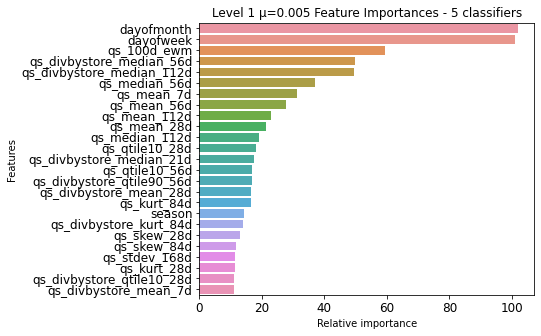

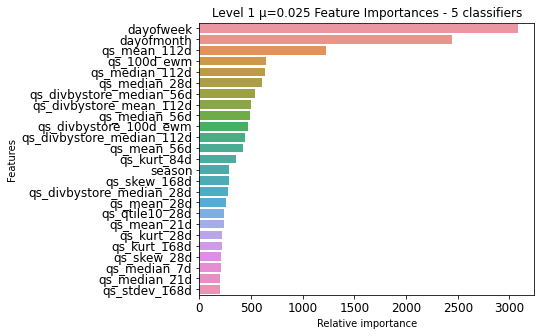

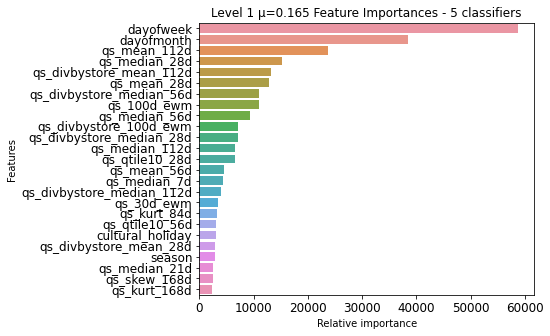

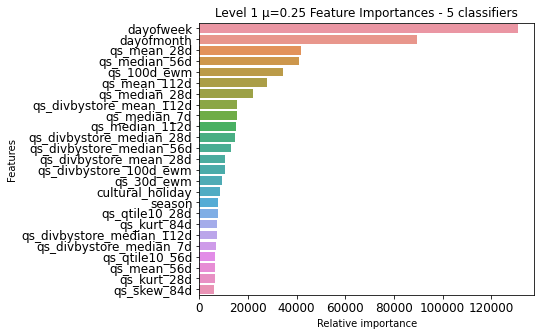

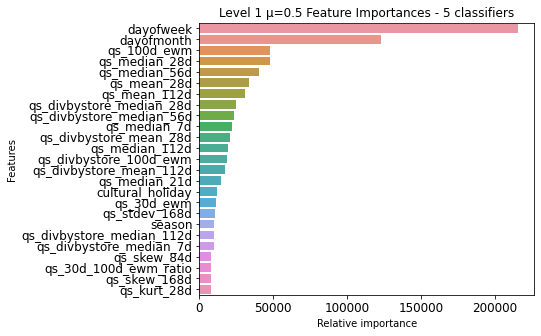

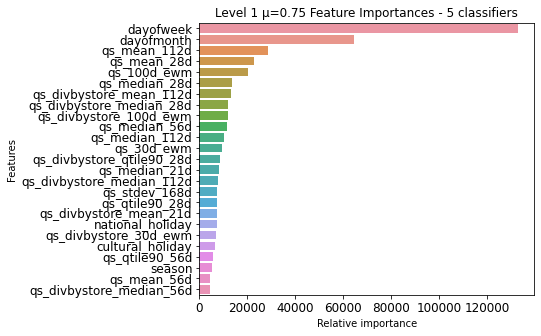

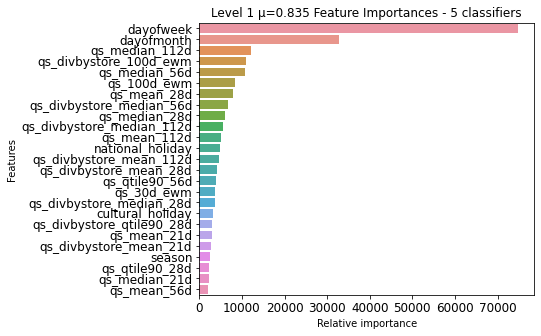

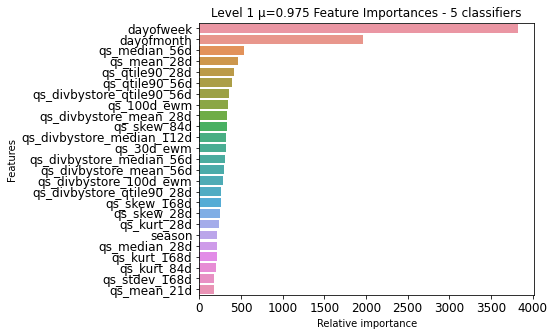

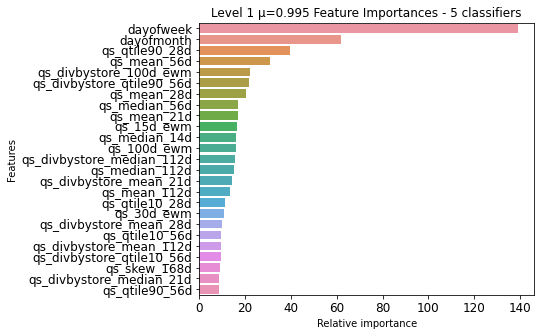

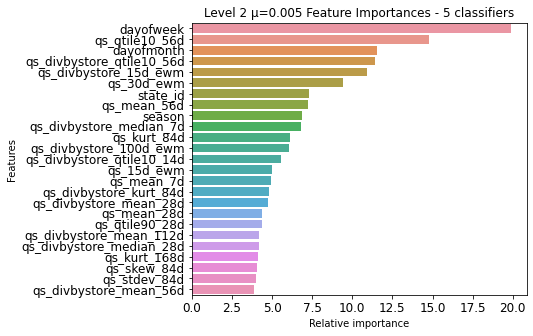

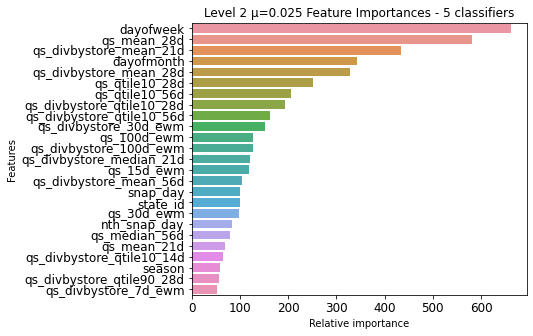

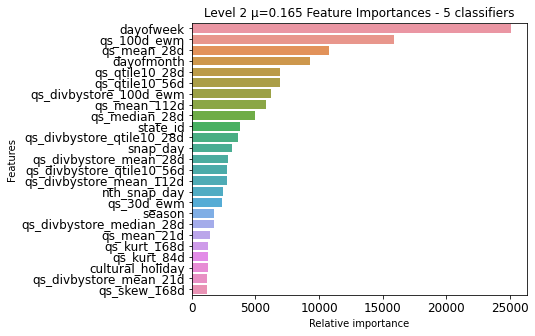

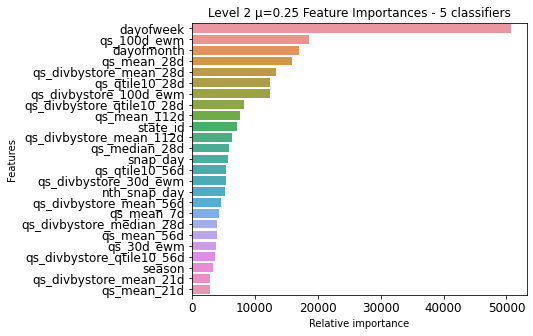

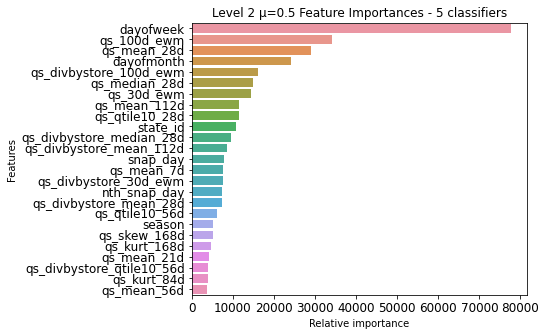

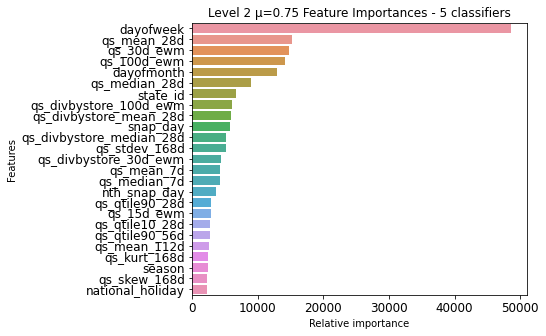

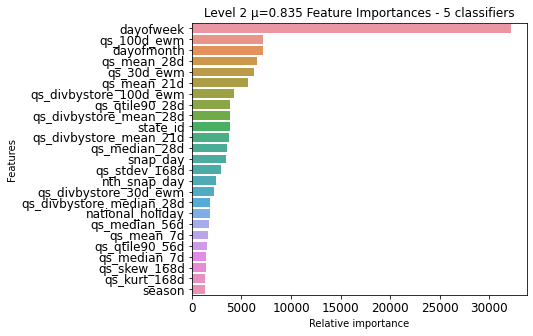

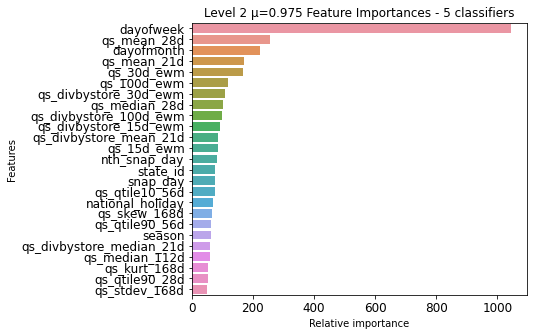

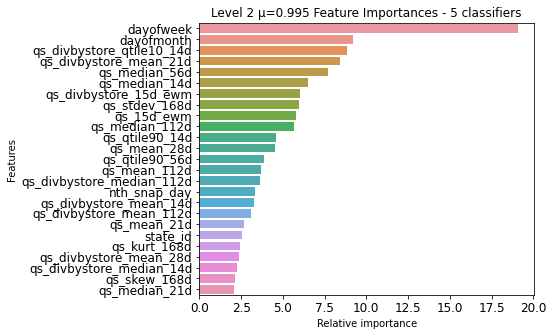

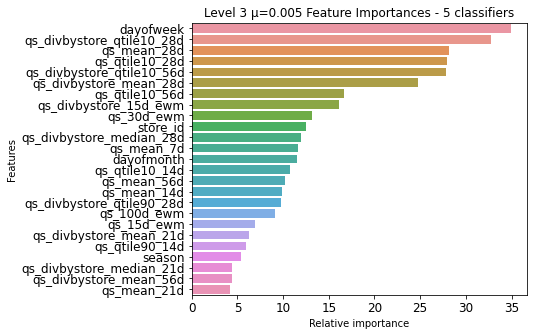

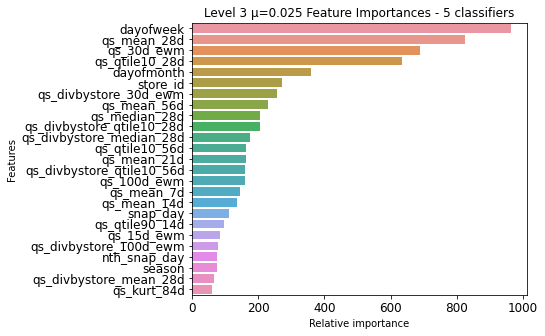

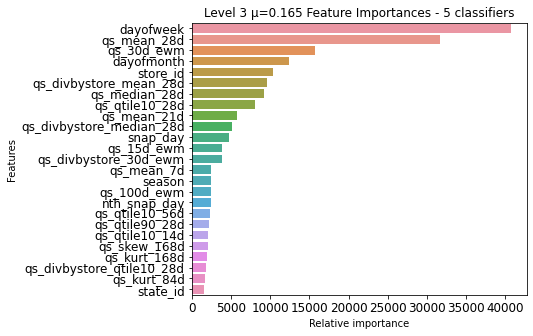

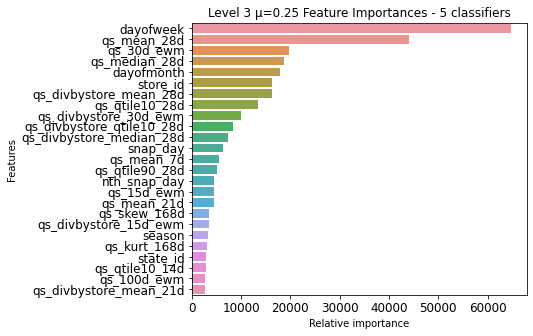

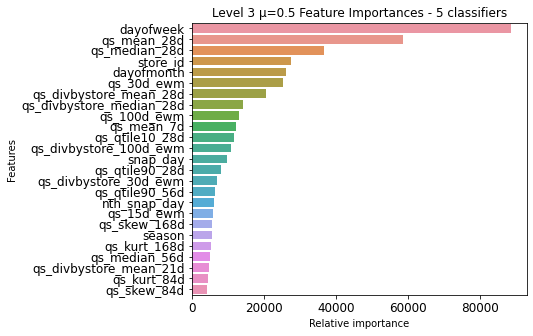

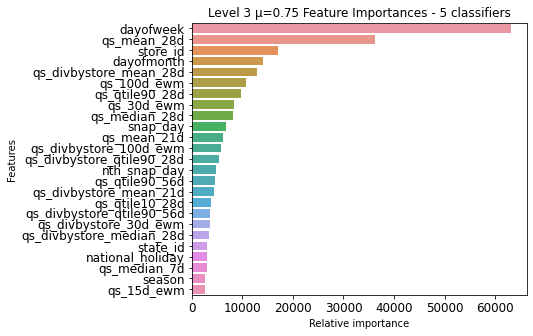

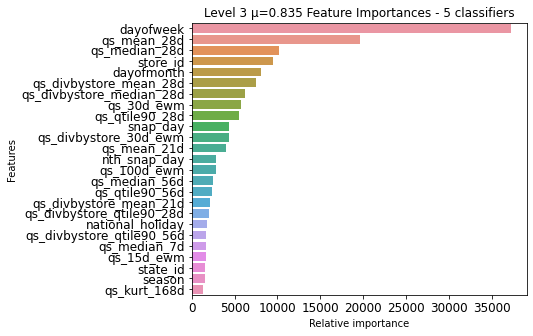

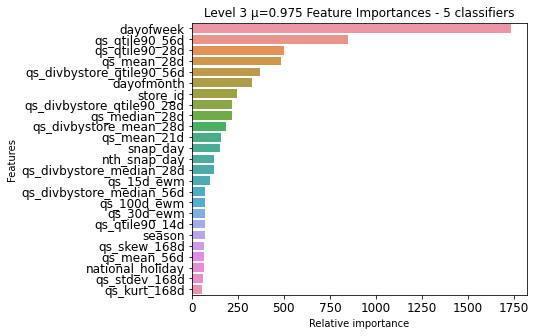

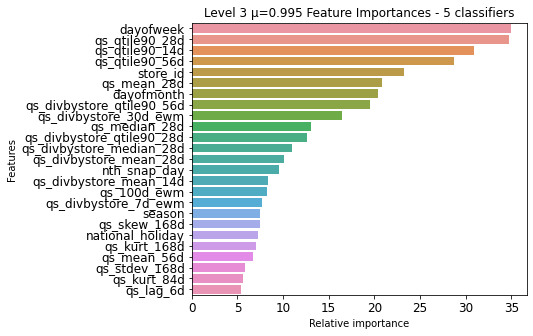

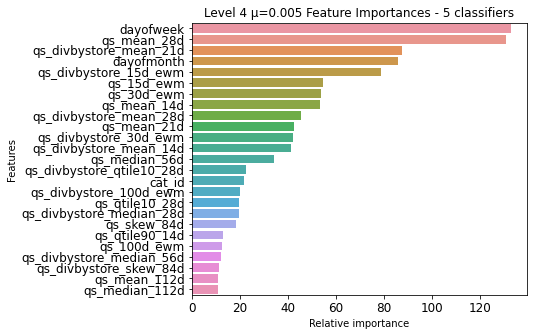

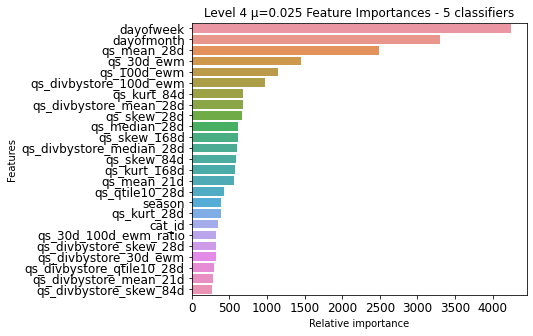

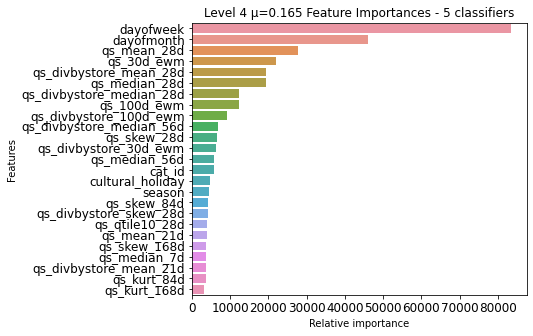

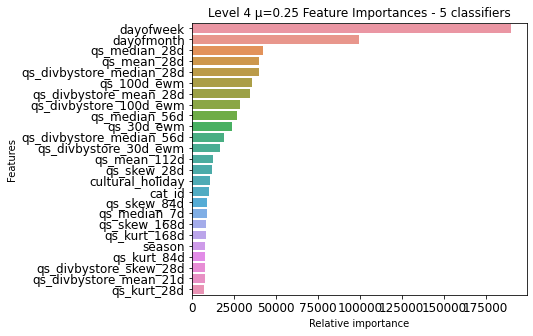

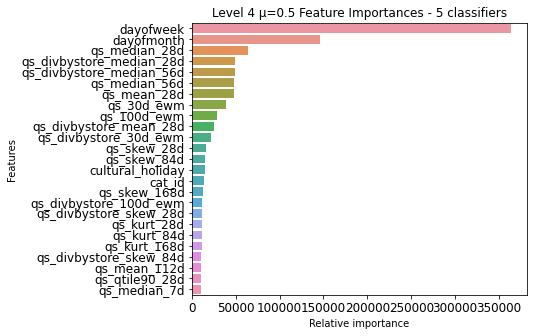

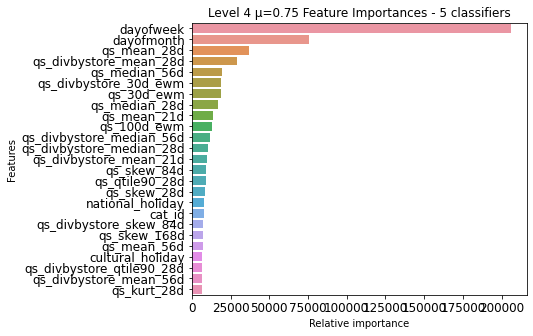

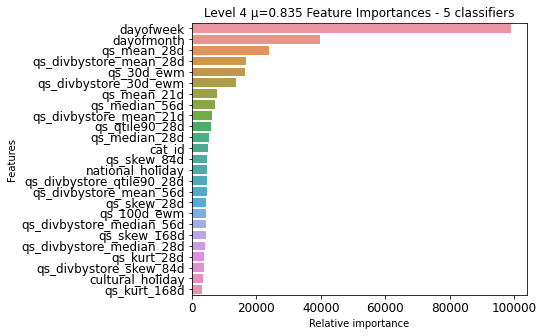

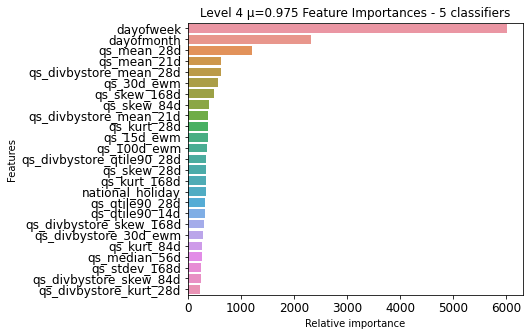

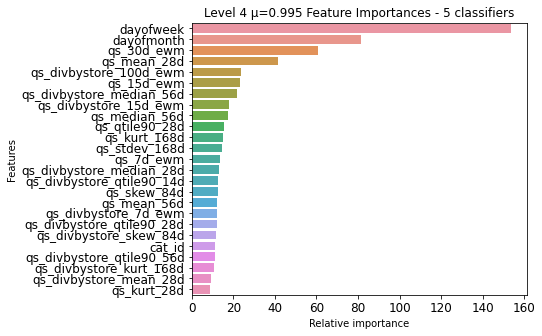

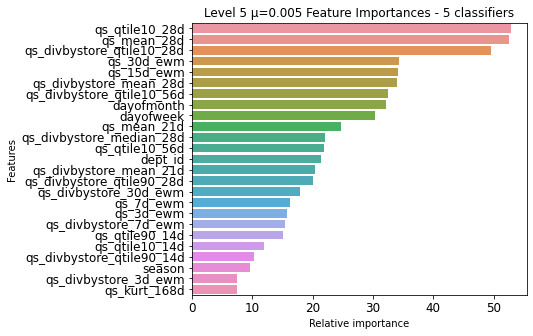

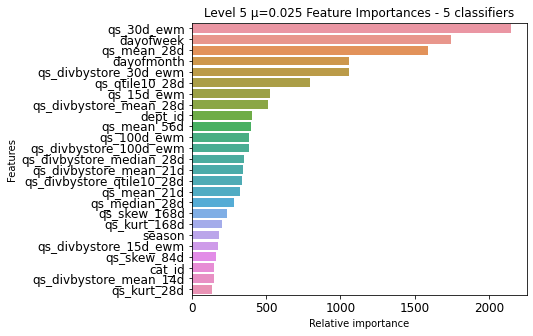

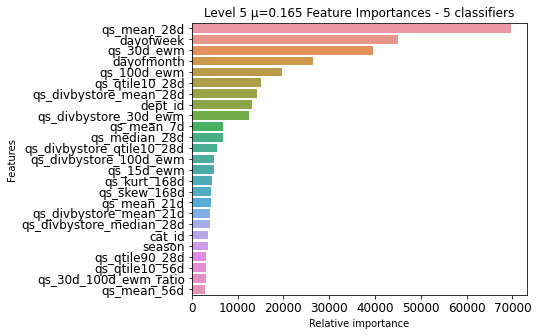

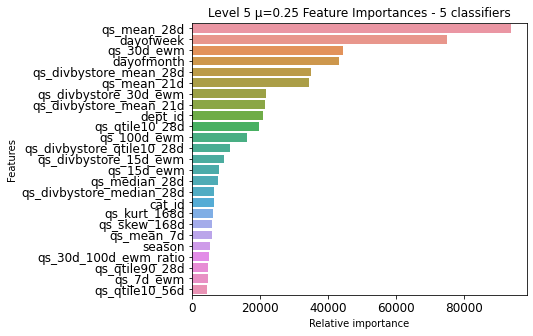

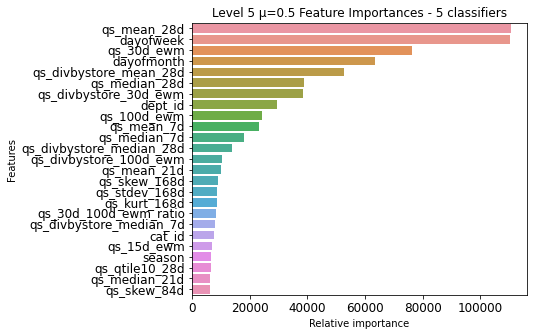

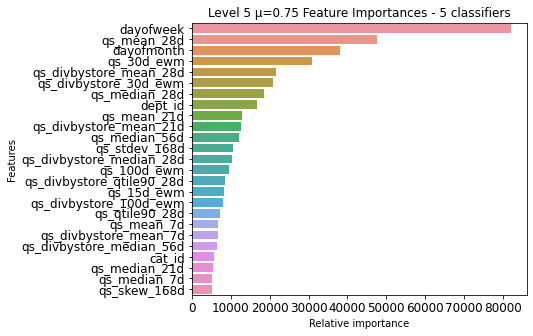

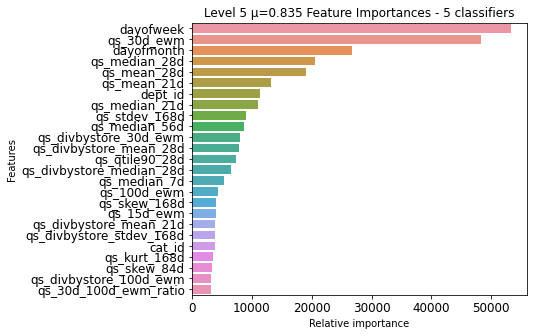

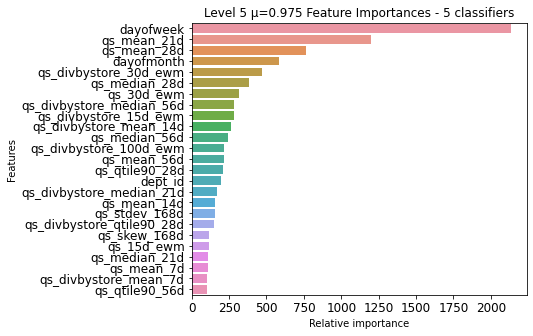

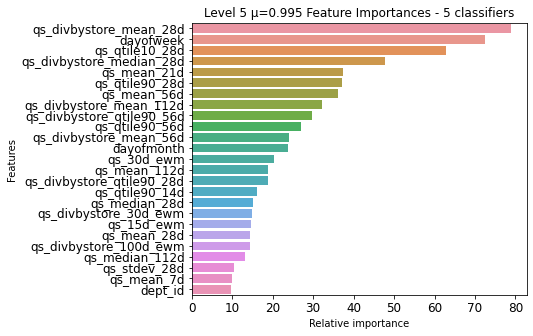

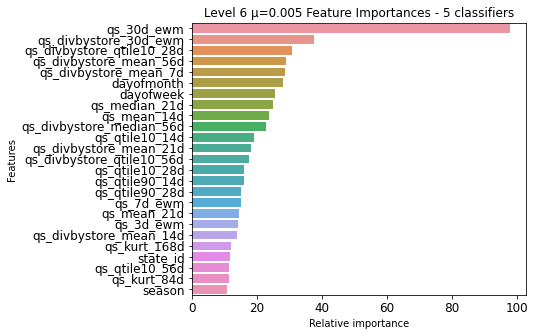

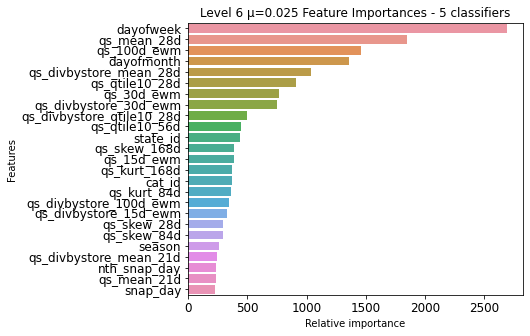

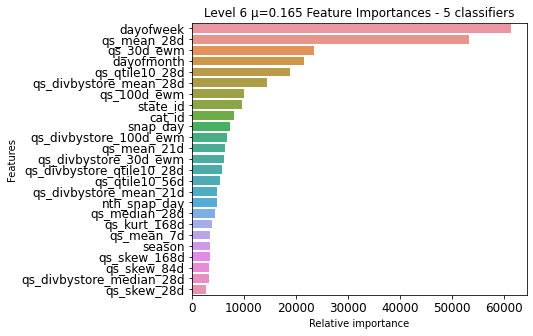

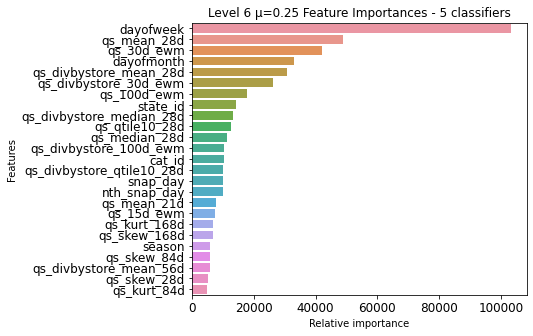

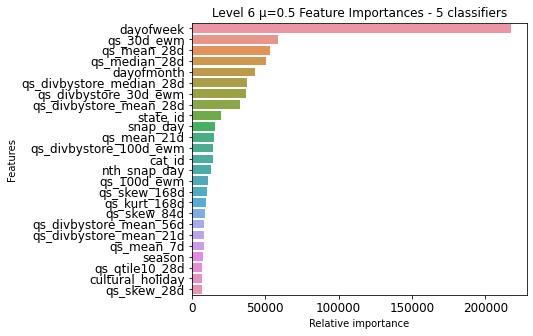

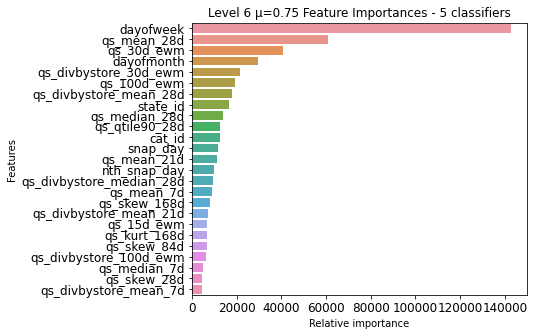

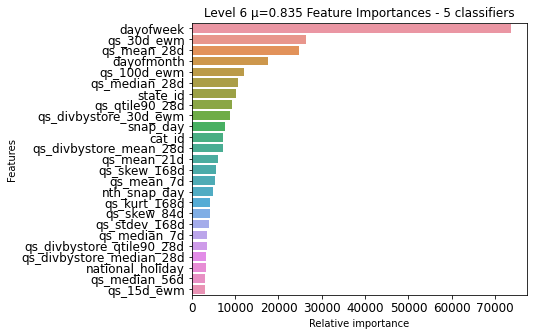

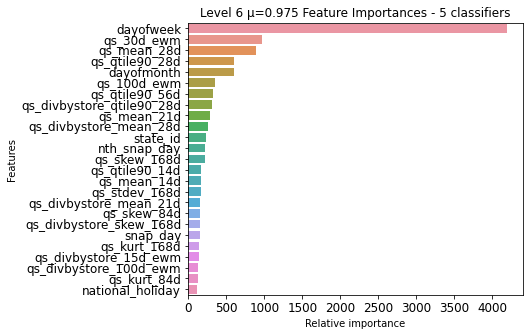

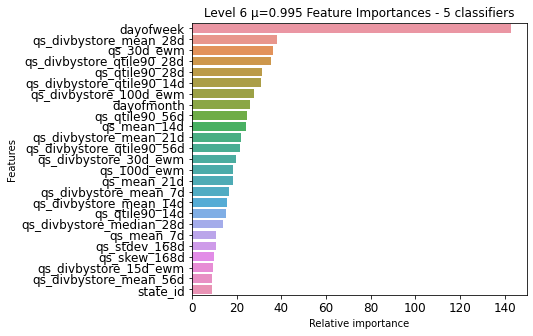

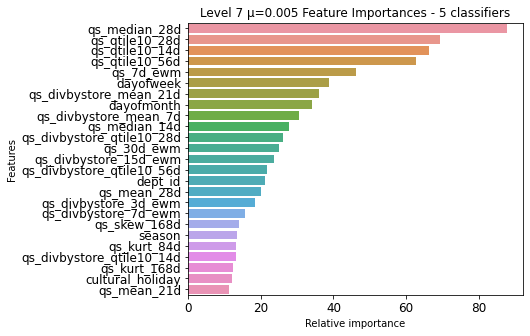

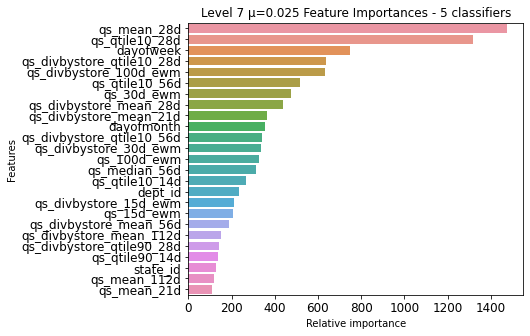

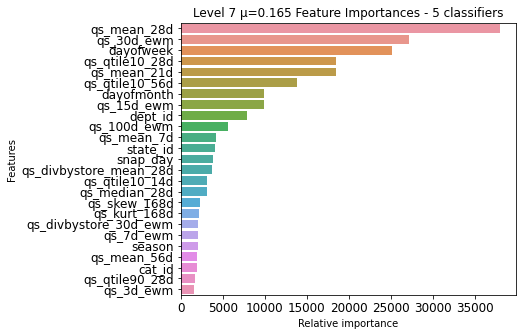

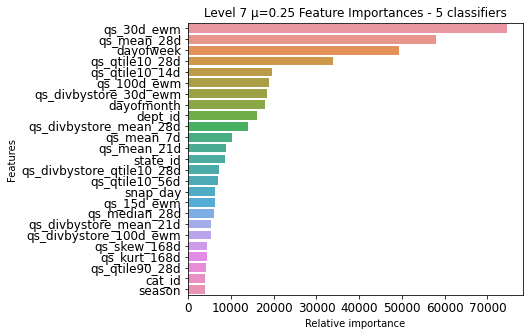

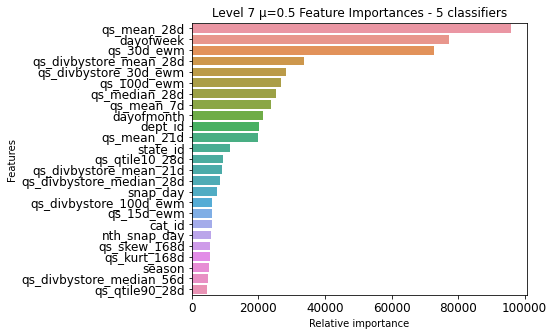

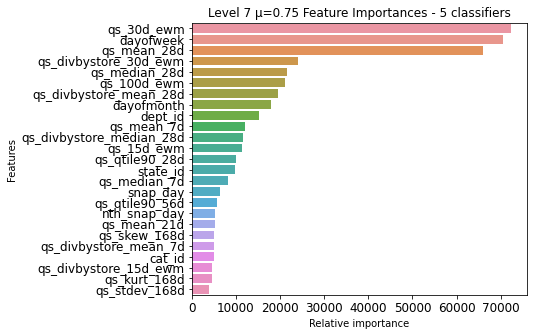

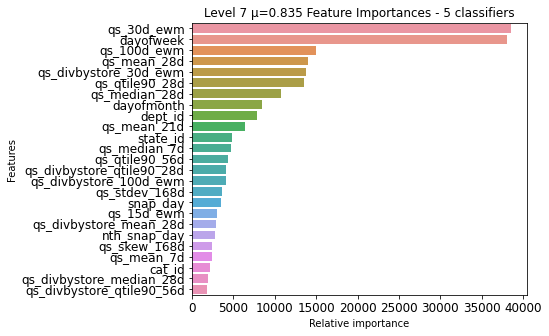

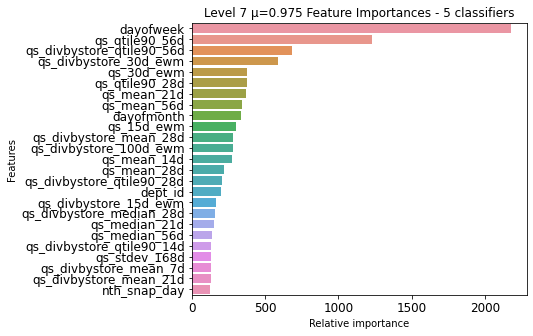

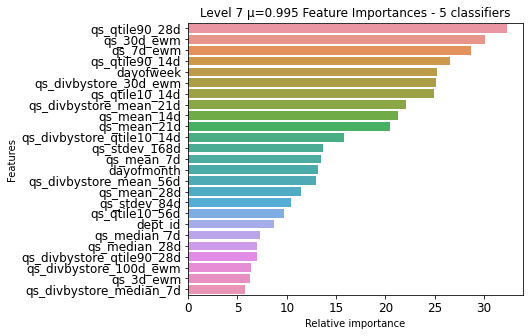

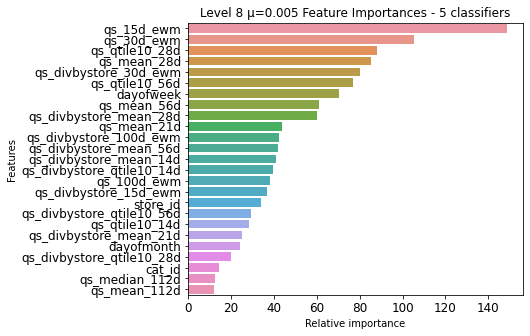

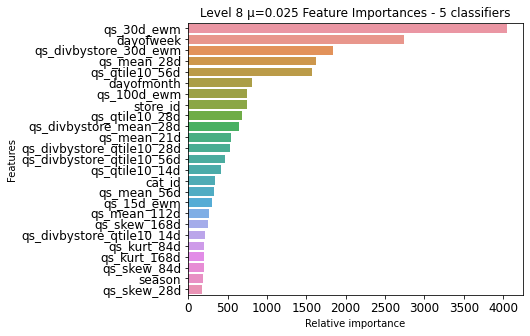

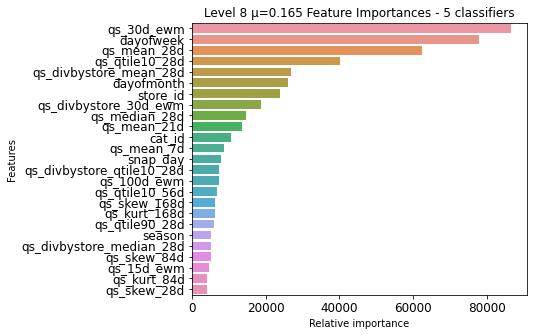

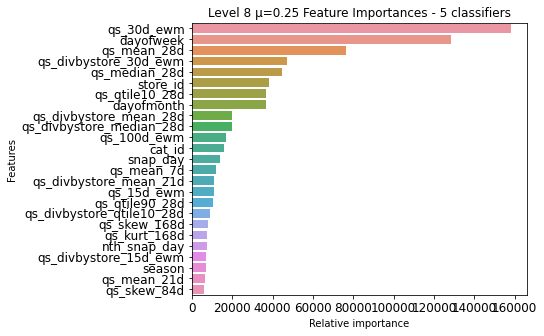

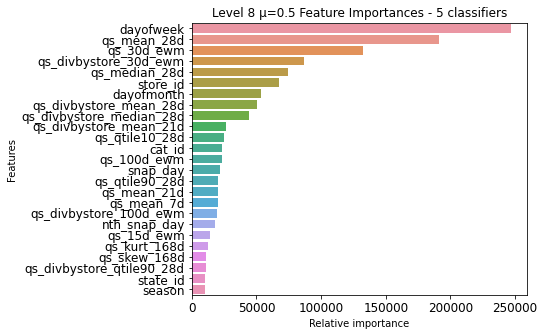

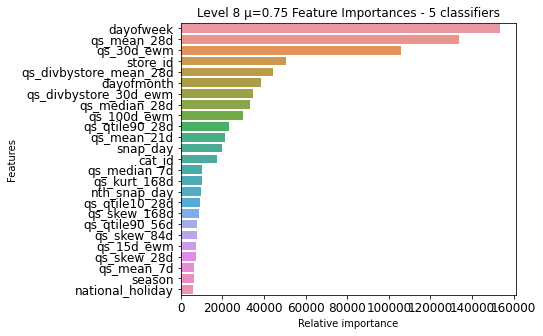

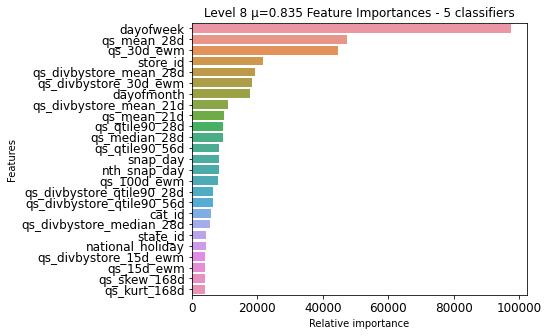

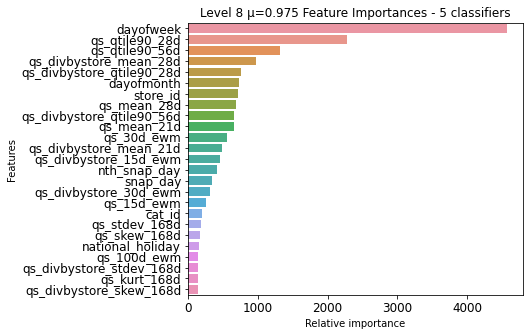

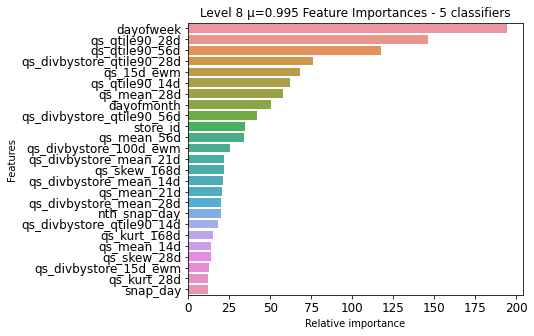

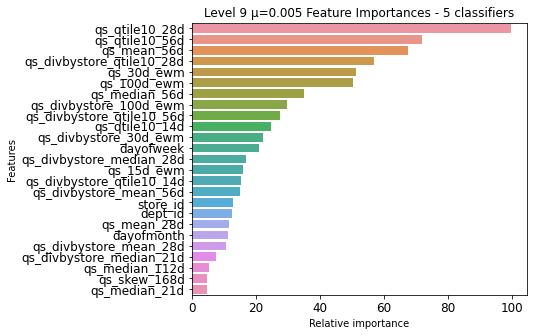

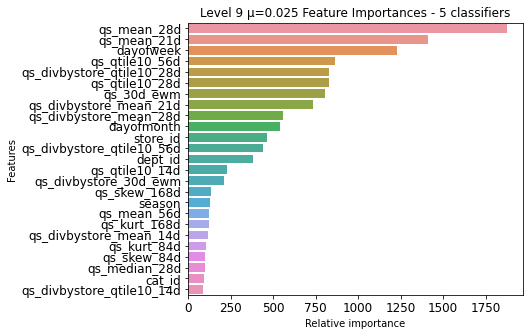

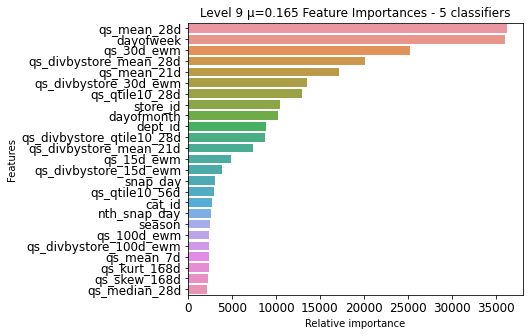

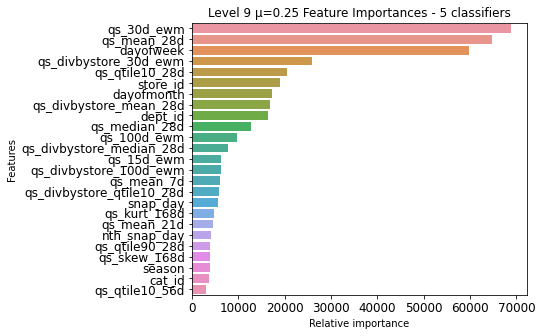

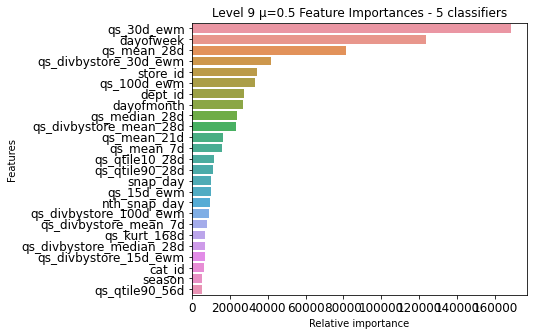

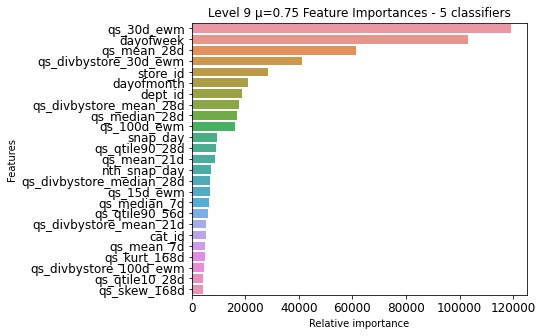

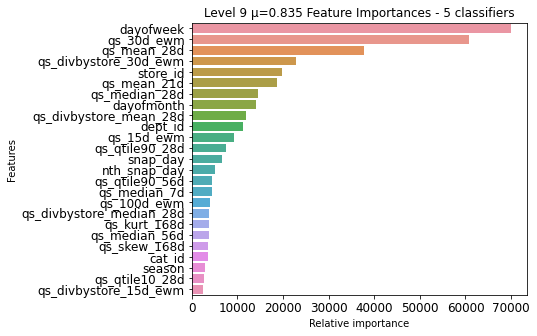

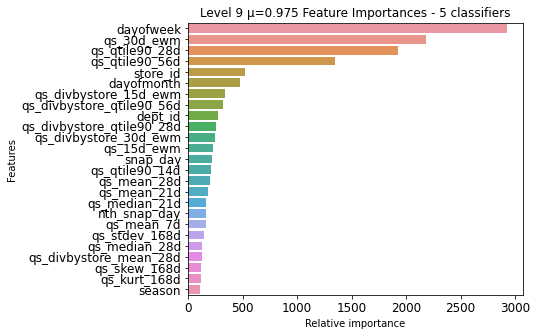

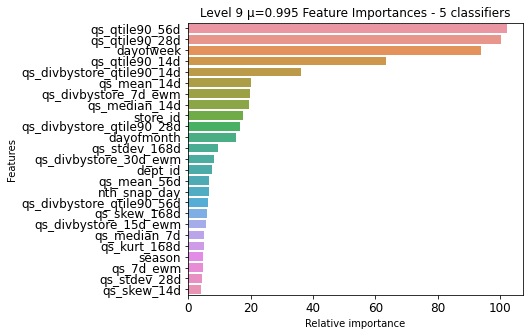

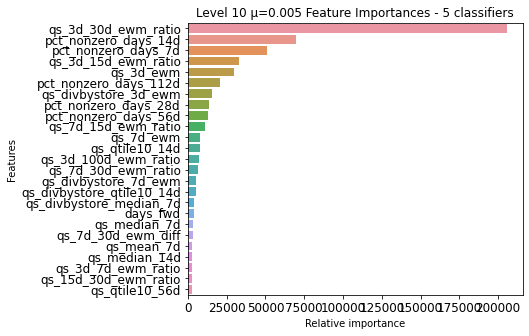

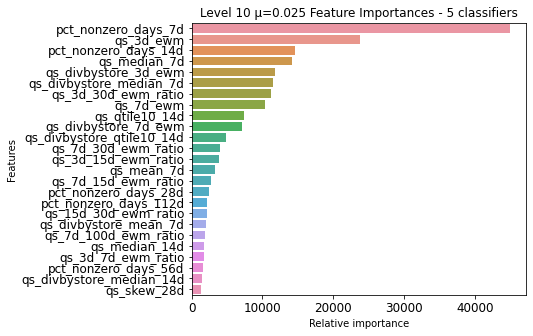

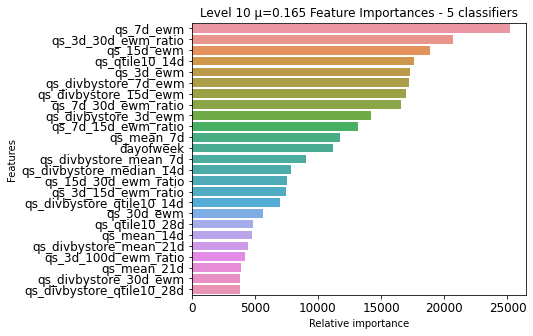

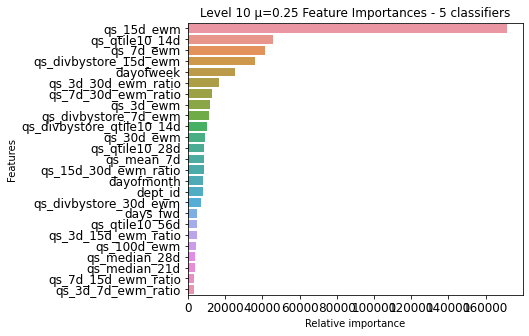

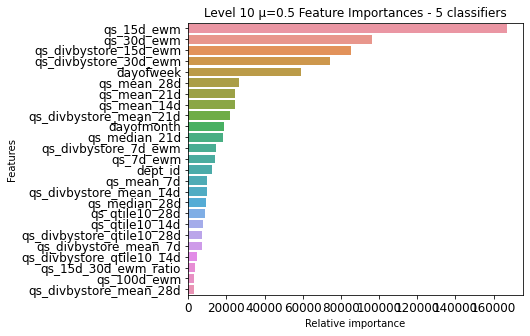

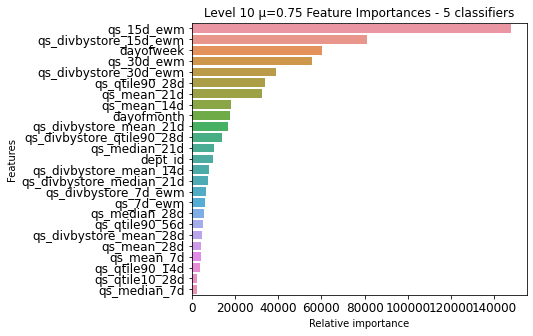

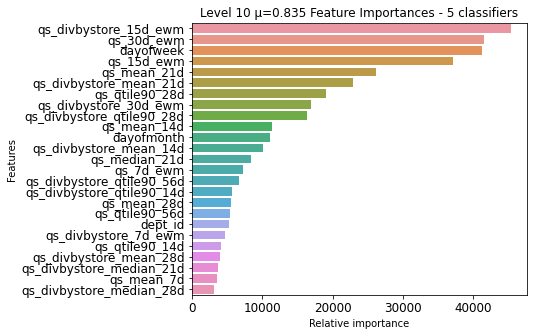

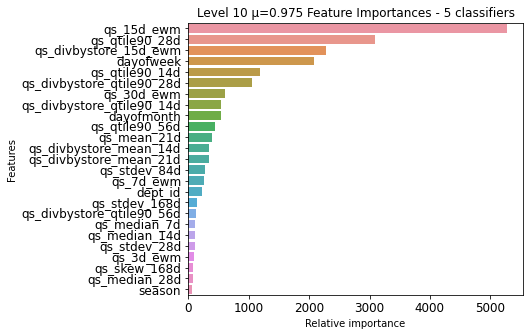

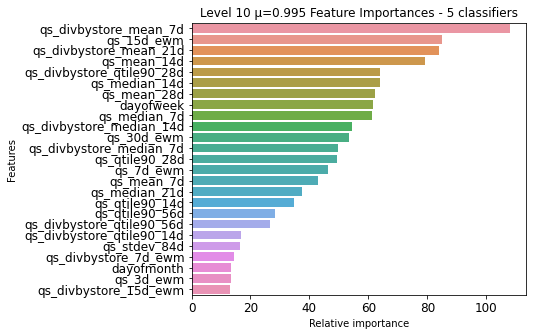

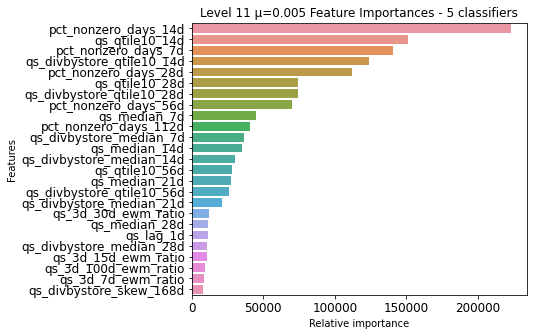

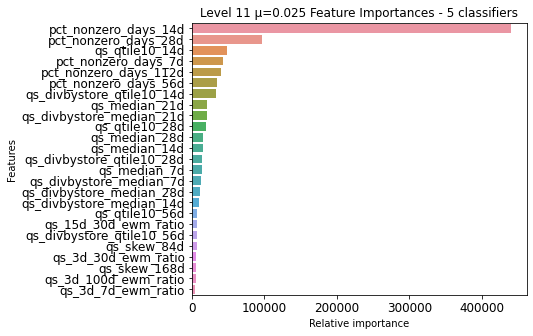

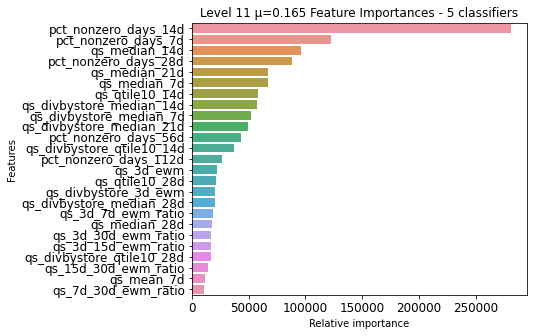

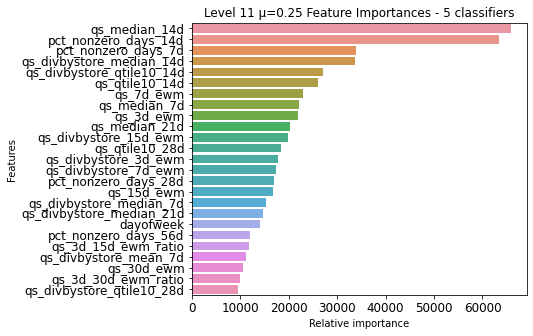

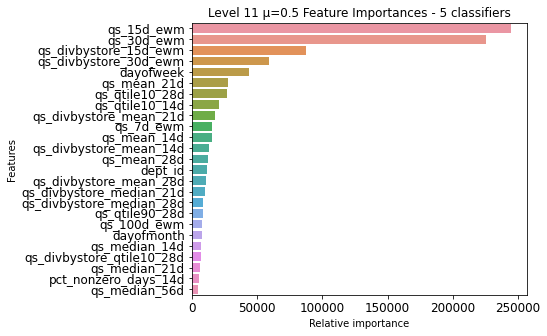

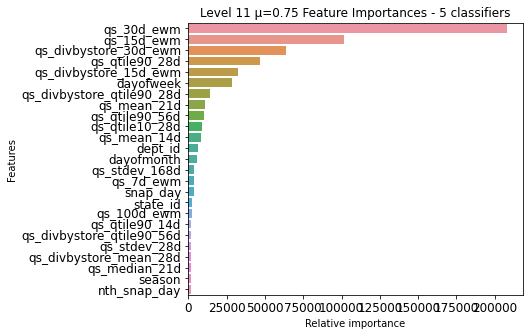

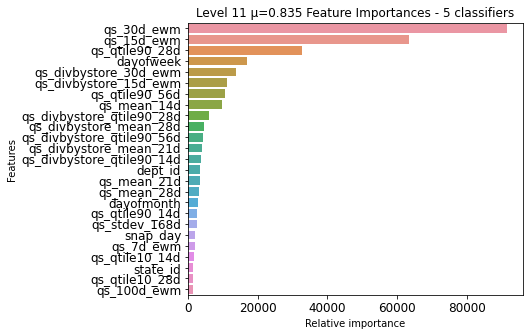

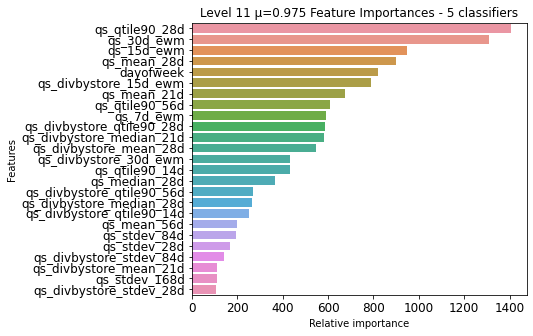

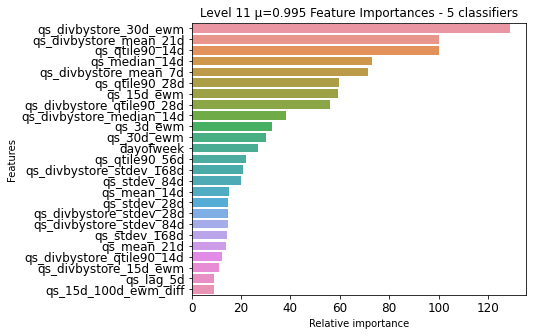

In [217]:
for level in sorted(clf_set.keys()):
    X = getSubsample(0.0001, level, 0.1)[0]
    print("Level {}:".format(level))
    for idx, q in enumerate(LEVEL_QUANTILES[level]):
        f = avg_FI([[q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]], X.columns, 25, 
                       title = "Level {} \u03BC={} Feature Importances".format(level, q))
    print(); print()

In [218]:
ramCheck()

2.3 GB used


In [219]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  179 s


### Predict

In [220]:
def avg(arr, axis = 0):
#     print( (arr<0).sum() )
#     return gmean(np.clip(arr, 0, None), axis = axis)
    return np.median(arr, axis = axis)

In [221]:
def predictSet(X, y, groups, scalers, clf_set):
    start_time = datetime.datetime.now(); 
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()
#     print(group_list)
    
    y_unscaled = y * scalers.scaler
    
    all_preds = []; ys=[]; gs = []; xs = []; scaler_stack = []
    for group_idx, group in enumerate(group_list):
        g = gc.collect()
        x_holdout = X[groups == group]
        y_holdout = y_unscaled[groups == group] 
        scalers_holdout = scalers[groups == group]
        groups_holdout = groups[groups == group]
        
        preds = np.zeros( (len(QUANTILES), len(y_holdout)), dtype=np.half)
        for q_idx, quantile in enumerate(QUANTILES):            
            q_preds = np.zeros( ( len(clf_set), len(y_holdout) ) )
            for bag_idx, clf in enumerate(clf_set):
                x_clean = x_holdout.drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])
                if group_idx >= len(clf_set[bag_idx]): # if out of sample year, blend all years
                    qs_preds = np.zeros( (group_idx, len(x_clean)) )
                    for gidx in range(group_idx):
                        qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean)
                    q_preds[bag_idx, :] = np.mean(qs_preds, axis = 0)
                else:
                    q_preds[bag_idx, :] = clf_set[bag_idx][group_idx][q_idx].predict(x_clean)
                
            q_preds = avg(q_preds) * scalers_holdout.scaler

            preds[q_idx, :] = q_preds
            
#             print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, quantile_loss(y_holdout, q_preds, quantile) ) )
        
        all_preds.append(preds)
        xs.append(x_holdout)
        ys.append(y_holdout)
        gs.append(groups_holdout)
        scaler_stack.append(scalers_holdout)
        print()
    y_pred = np.hstack(all_preds)
    scaler_stack = pd.concat(scaler_stack)
    y_true = pd.concat(ys)
    groups = pd.concat(gs)
    X = pd.concat(xs)
    
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return y_pred, y_true, groups, scaler_stack, X

In [222]:
def predictOOS(X, scalers, clf_set, QUANTILES, validation = False):
    start_time = datetime.datetime.now(); 
    
    group_list = [1 + i for i in range(0, len(clf_set[0]))]   
    if validation:
        group_list = np.zeros(len(clf_set[0]))
        group_list[-1] = 1
    
    
    divisor = sum(group_list)
    print(np.round([g / divisor for g in group_list], 3)); print()
    
    x_holdout = X
    scalers_holdout = scalers 

    preds = np.zeros( (len(clf_set[0][0]), len(x_holdout)), dtype=np.float32)
    for q_idx in range( len(clf_set[0][0])): # loop over quantiles
        print(u'Predicting for \u03BC={}'.format( QUANTILES[q_idx]) )
        
        q_preds = np.zeros( ( len(clf_set), len(x_holdout) ), dtype = np.float32 )
        for bag_idx, clf in enumerate(clf_set):
            x_clean = x_holdout # .drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])
            qs_preds = np.zeros( (len(group_list), len(x_clean)), dtype = np.float32 )
            for gidx in range(len(group_list)):
                if group_list[gidx] > 0: 
                    qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean) * group_list[gidx] / divisor
            q_preds[bag_idx, :] = np.sum(qs_preds, axis = 0)

        q_preds = np.mean(q_preds, axis = 0) * scalers_holdout.scaler

        preds[q_idx, :] = q_preds
 
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return preds

In [223]:
def wspl(true, pred, weights, trailing_vol, quantile = 0.5):
    loss = weights * np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) ) / trailing_vol
    return np.mean(loss) / np.mean(weights)   
 

### Random Sample Scoring

In [224]:
VALIDATION = -1

In [225]:
RSEED = 11


In [226]:
N_REPEATS = 20 if ID_FILTER != 'FOODS' else 10

In [227]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  179 s


In [228]:
ramCheck()

2.3 GB used


In [229]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
               series_features: 29.5 MiB
                        y_full:  2.3 MiB
                         train:  1.4 MiB
                   daily_sales:  1.4 MiB
                 train_flipped:  1.3 MiB
                          _164:  1.3 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB


In [230]:
### NEXT: FOCUS ON STORE-ITEM CV:
# 2. Easy CV: diffsquared, then expanding means of it, stored on file
#             (y_true - y_pred) ** 2;  then for each prediction, just lookup denom value and divide by it
#             finally take sqrt(mean())
#             easy
# Probably just as fast to predict for every lag on every point, so comes out instantly as array_match;
# for now, it's an individual store-item onlyss

# doesn't make sense to go up a level until models predict just those, and apply that as overlay;
# then re-calc lower level, etc.

In [231]:
# copy in group loop from finance module, same for params and lgb, and printout CV code

# CV metric is tricky... differs for every day and every product and every lag 2k * 30k * 30 = 4gb...
# probably calculate this on-the-fly for a random subsample and see if converges...


In [232]:
# could predict all, or just call prediction code in full for one item and see; plot all 28-d forecasts vs ACTUAL
# or single-path printouts of history and pred/actual;
# ideally multiple items shown together etc.;


### Make Submission

In [233]:
MEM_CAPACITY = 1e6

In [234]:
MAX_RUNS = 250
MIN_RUNS = 10

In [235]:
all_predictions = {}
for level in sorted(list(set(levels.unique()) & set(clf_set.keys()))):
    print('\n\nCreating Out-of-Sample Predictions for Level {}\n'.format(level))
    
    final_base = 'd_1941'

    assert (final_base in ['d_1941', 'd_1913'])
    if final_base == 'd_1941':
        suffix = 'evaluation'
    elif final_base == 'd_1913':
        suffix = 'validation'
        
    print('   predicting 28 days forward from {}'.format(final_base))
    final_features = series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
                                         (series_features.series.map(series_id_level) == level) ]

    print('    for {} series'.format(len(final_features)))
    
    SS_FRAC, SCALE_RANGE = P_DICT[level if level < 12 else ID_FILTER]; 
    SS_FRAC = SS_FRAC * 0.8
    print('   scale range of {}'.format(SCALE_RANGE))
    
    
    if level <= 9:
        X = []
        for df in range(0,28):
            Xi = final_features.copy()
            Xi['days_fwd'] = df + 1
            X.append(Xi)
        X = pd.concat(X, ignore_index = True); del Xi; del final_features;

        Xn = np.power(X.weights, 2)
        Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
        Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
        
        print('   average repeats: {:.0f}'.format(Xn.mean()))
        print('   median repeats: {:.0f}'.format(Xn.median()))
        print('   max repeats: {:.0f}'.format(Xn.max()))

        X = X.loc[np.repeat(Xn.index, Xn)]

        X, y, groups, scalers = getXYG(X, scale_range = SCALE_RANGE, oos = True)
        Xd = X.d;  Xseries = X.series
        X.drop(columns=['d', 'series'], inplace = True)

        print(X.shape)
        y_pred = predictOOS(X, scalers, clf_set[level], LEVEL_QUANTILES[level], suffix == 'validation'); print()

        predictions = pd.DataFrame(y_pred.T, index=X.index, columns = LEVEL_QUANTILES[level])
        predictions = pd.concat((predictions, scalers), axis = 'columns')
        predictions['series'] = Xseries
        predictions['d'] = Xd
        predictions['days_fwd'] = X.days_fwd.astype(np.int8)
        predictions['y_true'] = y * scalers.scaler
#         break;
        ramCheck()

        predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                        dict([(col, 'mean') for col in predictions.columns 
                                  if col not in ['series', 'd', 'days_fwd']]\
                                 + [('days_fwd', 'count')])  )\
                    .rename(columns = {'days_fwd': 'ct'}).reset_index()
        predictions.days_fwd = predictions.days_fwd.astype(np.int8)

    else: # levels 10, 11, 12
        
        predictions_full = []
        
        for df in range(0,28):
            print( '\n Predicting {} days forward from {}'.format(df + 1, final_base))
            X = final_features.copy()
            X['days_fwd'] = df + 1

            Xn = np.power(X.weights, 1.5)
            Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
            Xn = (Xn * MEM_CAPACITY / Xn.sum()).clip(MIN_RUNS, MAX_RUNS)
            
            print('   average repeats: {:.0f}'.format(Xn.mean()))
            print('   median repeats: {:.0f}'.format(Xn.median()))
            print('   max repeats: {:.0f}'.format(Xn.max()))
            
            X = X.loc[np.repeat(Xn.index, Xn)]

            X, y, groups, scalers = getXYG(X, scale_range = SCALE_RANGE, oos = True)
            Xd = X.d;  Xseries = X.series
            X.drop(columns=['d', 'series'], inplace = True)

            print(X.shape)
            y_pred = predictOOS(X, scalers, clf_set[level], LEVEL_QUANTILES[level], suffix == 'validation'); print()

            predictions = pd.DataFrame(y_pred.T, index=X.index, columns = LEVEL_QUANTILES[level])
            predictions = pd.concat((predictions, scalers), axis = 'columns')
            predictions['series'] = Xseries
            predictions['d'] = Xd
            predictions['days_fwd'] = X.days_fwd.astype(np.int8)
            predictions['y_true'] = y

            ramCheck()

            predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                            dict([(col, 'mean') for col in predictions.columns 
                                      if col not in ['series', 'd', 'days_fwd']]\
                                     + [('days_fwd', 'count')])  )\
                        .rename(columns = {'days_fwd': 'ct'}).reset_index()
            predictions.days_fwd = predictions.days_fwd.astype(np.int8)
            predictions_full.append(predictions)
            
        predictions = pd.concat(predictions_full); del predictions_full
 
    all_predictions[level] = predictions; del predictions



Creating Out-of-Sample Predictions for Level 1

   predicting 28 days forward from d_1941
    for 1 series
   scale range of 0.7
   average repeats: 250
   median repeats: 250
   max repeats: 250
No State Ids
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:01
(7000, 126)
[0.067 0.133 0.2   0.267 0.333]

Predicting for μ=0.005
Predicting for μ=0.025
Predicting for μ=0.165
Predicting for μ=0.25
Predicting for μ=0.5
Predicting for μ=0.75
Predicting for μ=0.835
Predicting for μ=0.975
Predicting for μ=0.995
Bag Prediction Time: 0:00:04

2.2 GB used


Creating Out-of-Sample Predictions for Level 2

   predicting 28 days forward from d_1941
    for 3 series
   scale range of 0.7
   average repeats: 250
   median repeats: 250
   max repeats: 250
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
(21000, 130)
[0.067 0.133 0.2   0.267 0.3

In [236]:
subpred

NameError: name 'subpred' is not defined

In [237]:
if suffix == 'validation':

    losses = pd.DataFrame(index=LEVEL_QUANTILES[level])
    for level in sorted(all_predictions.keys()):
        predictions = all_predictions[level]
        subpred = predictions
        q_losses = []
        for quantile in LEVEL_QUANTILES[level]:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  subpred.weights, subpred.trailing_vol, quantile)))
        
#         print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values)
        losses[level] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values


#         print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
    print(losses); print(); print()
    print(losses.mean())

In [238]:
if suffix == 'validation':
    losses.plot()

In [239]:
# predictions

In [240]:
train_flipped.shape

(1941, 154)

In [241]:
# series_feeature

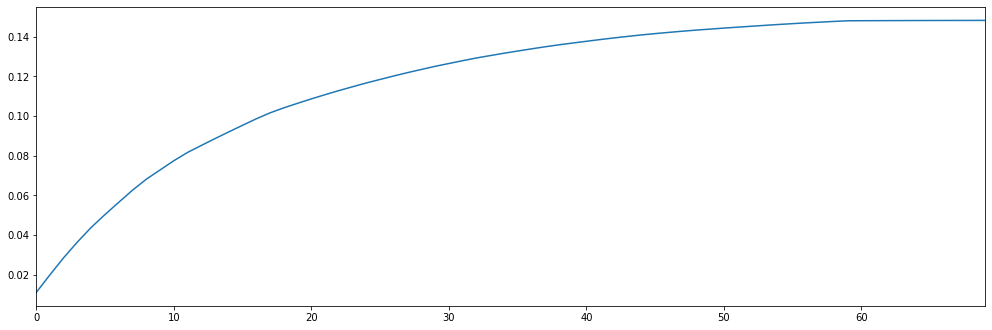

In [242]:
(series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
                                         (series_features.series.map(series_id_level) == level) ]\
        .sort_values('weights', ascending = False).reset_index().weights.astype(np.float32) ** 1.5).cumsum().plot()

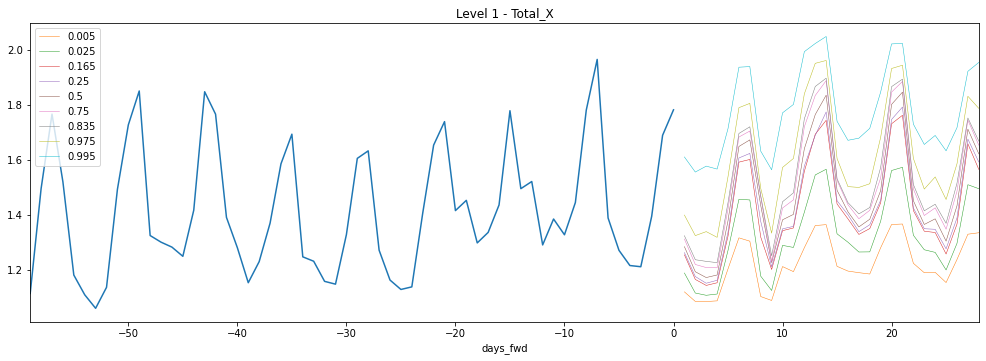

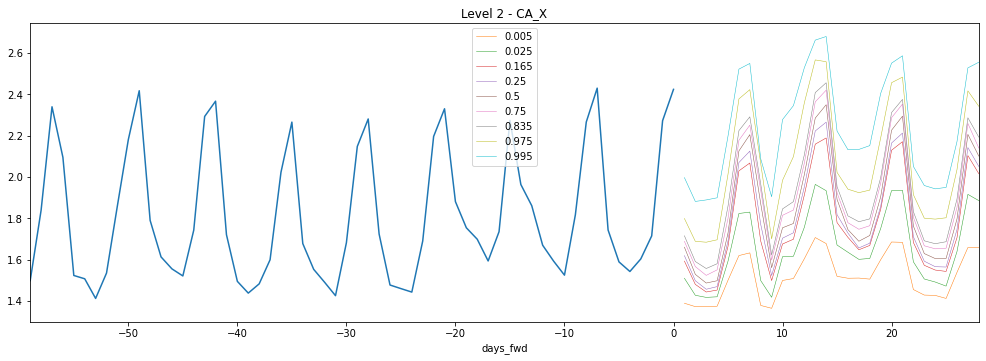

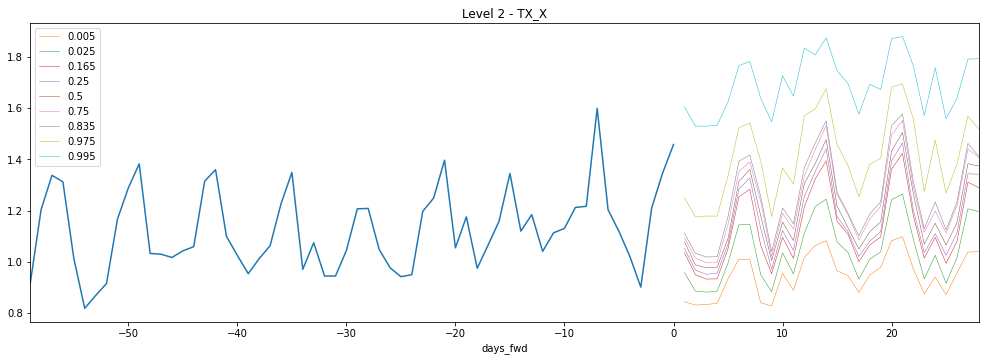

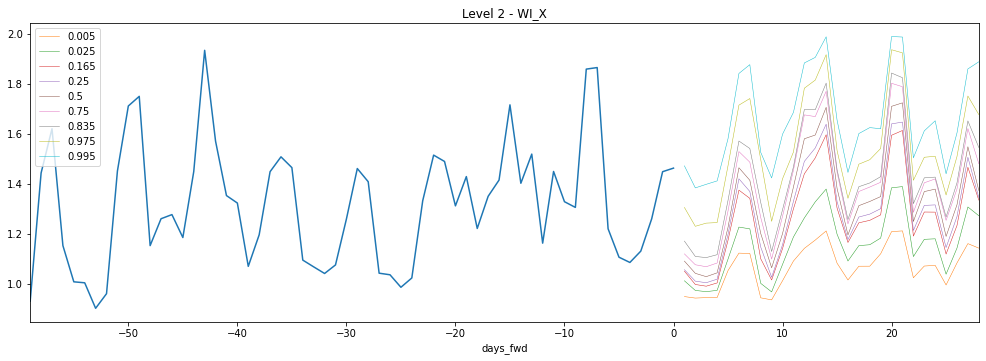

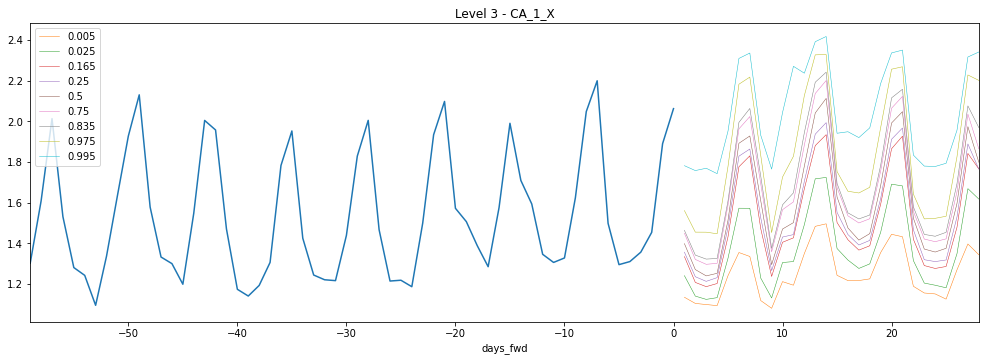

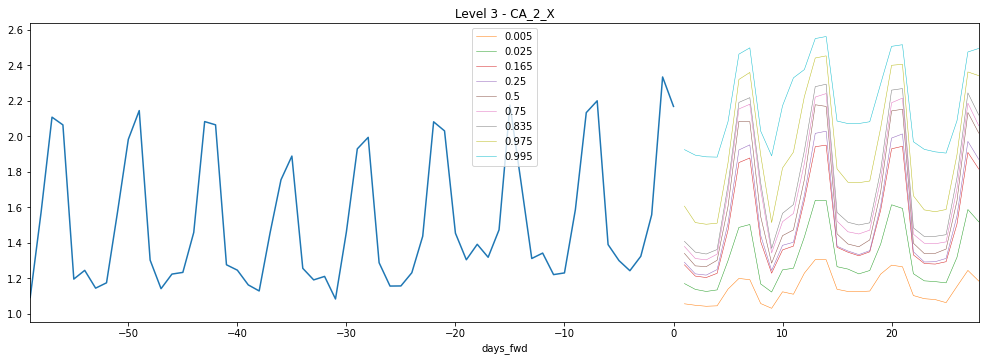

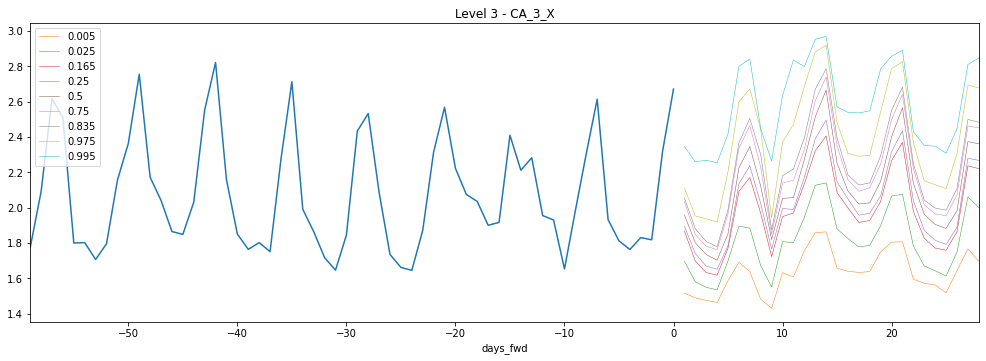

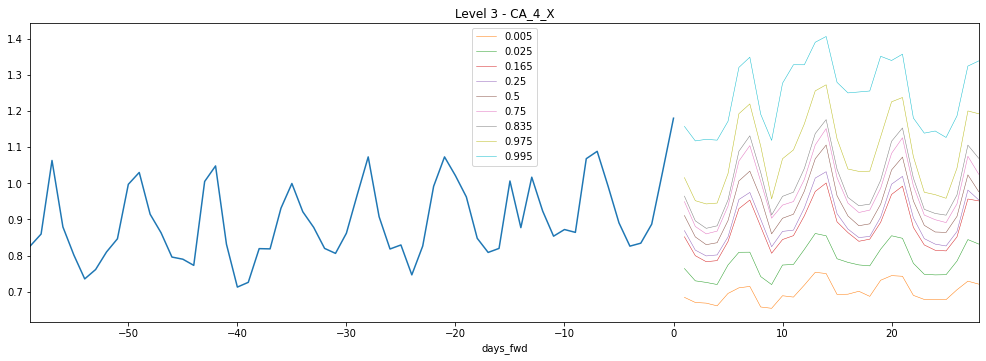

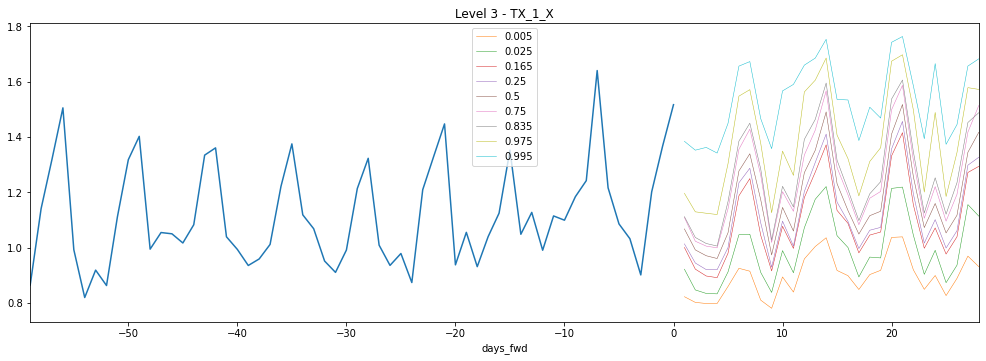

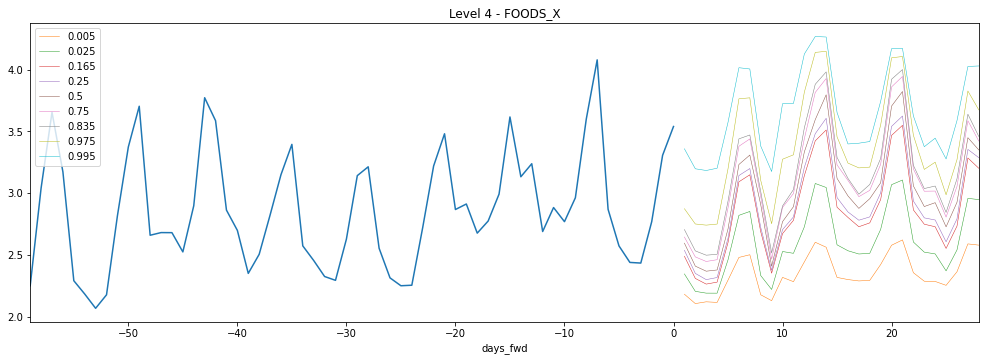

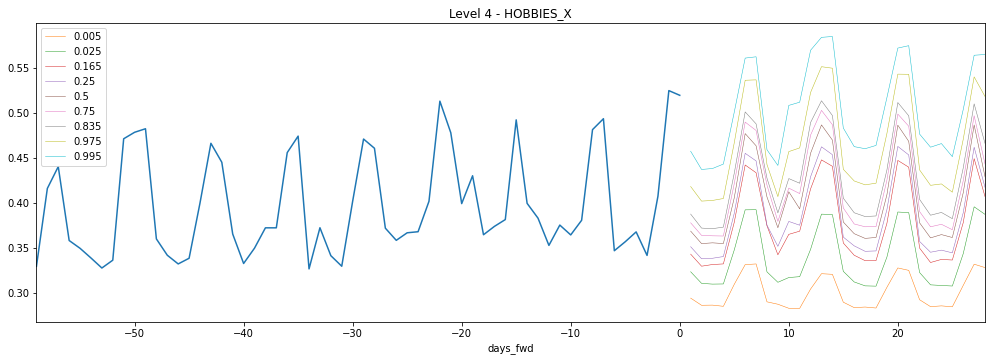

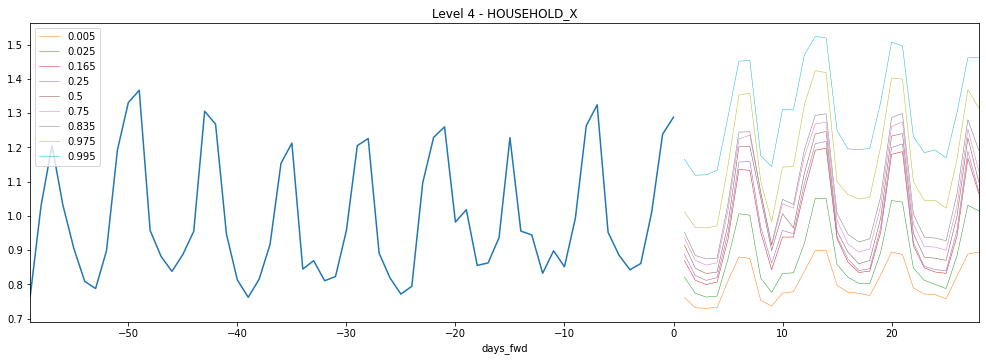

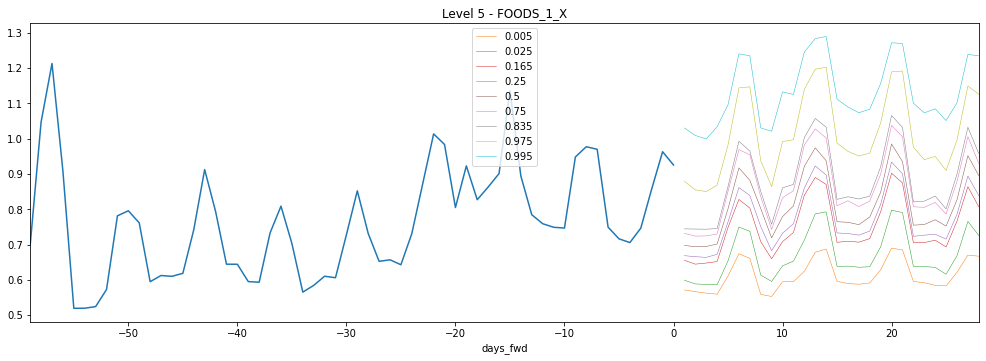

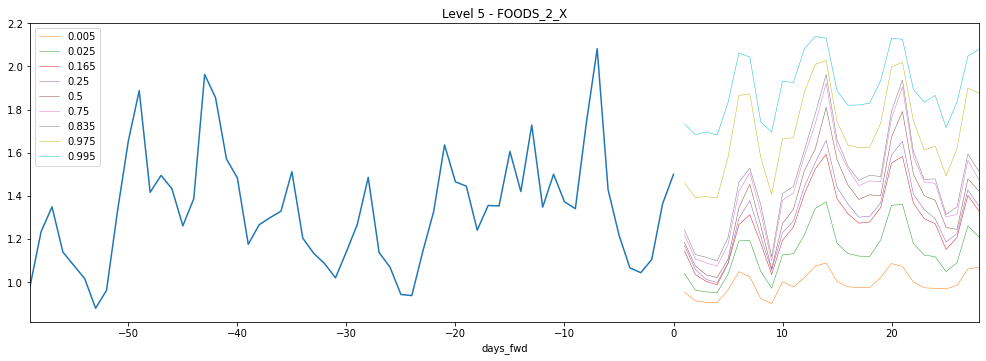

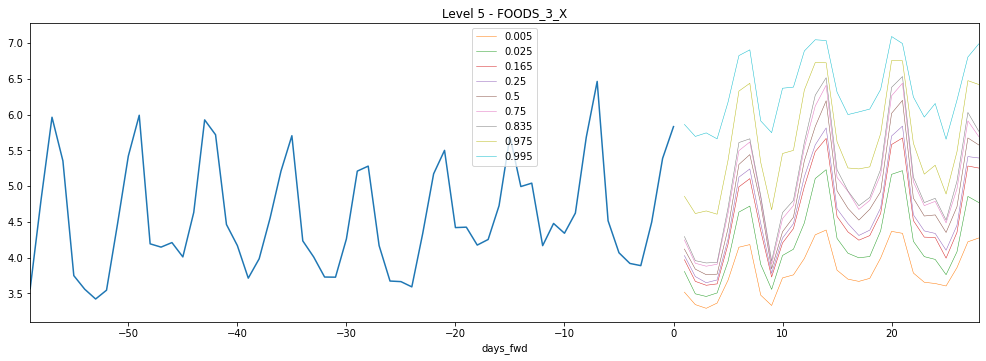

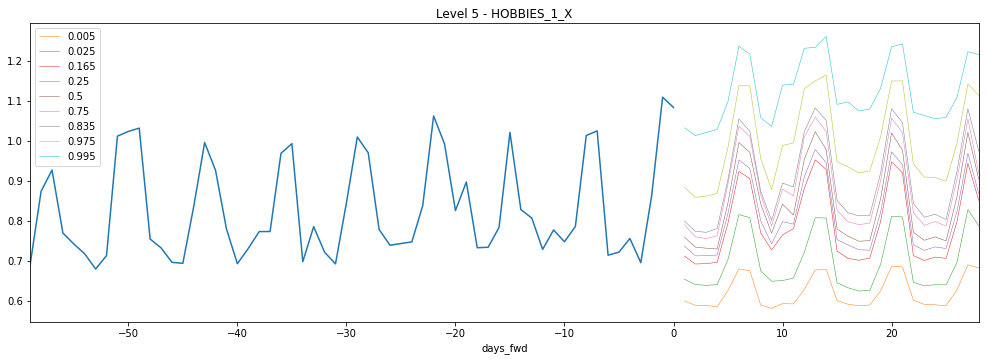

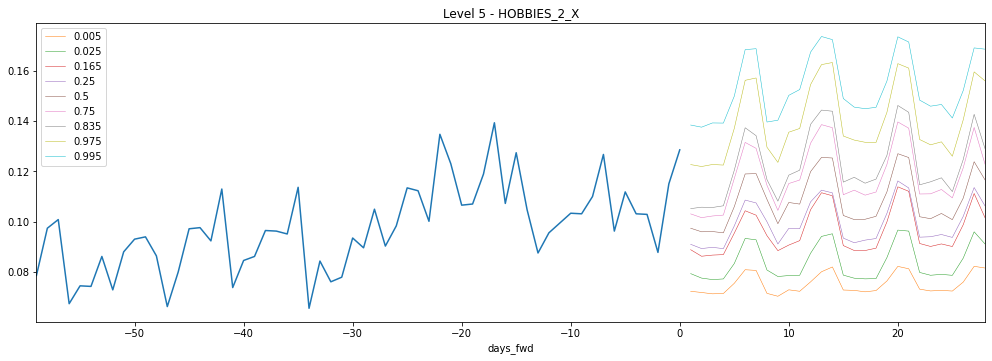

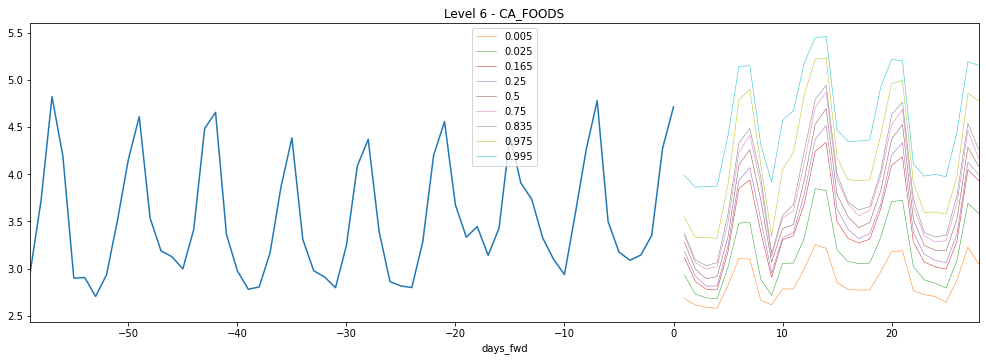

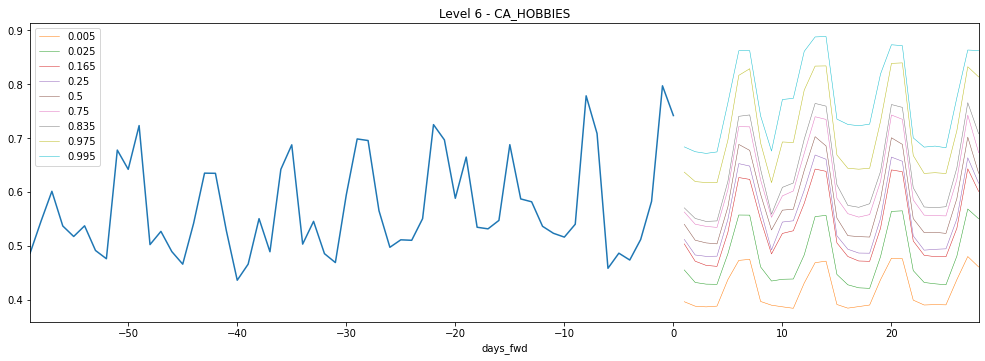

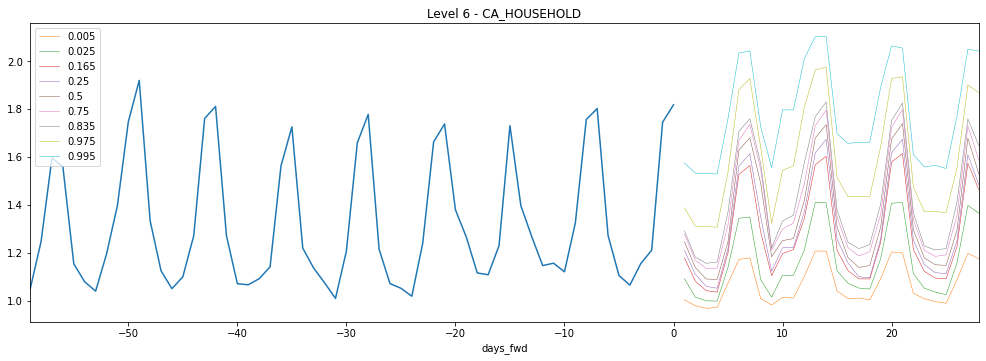

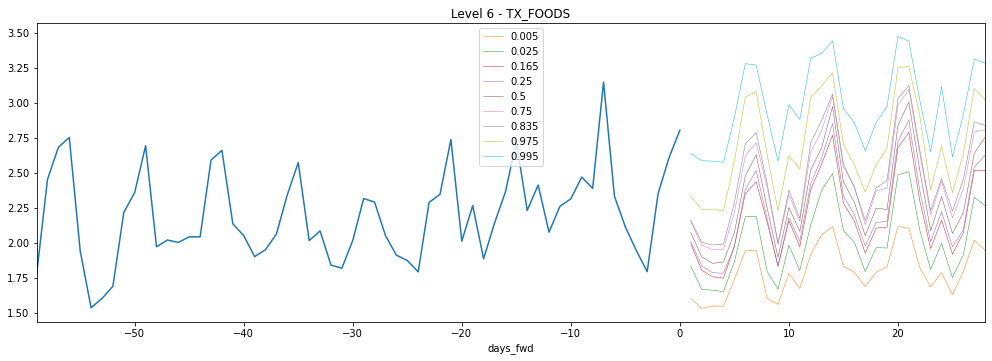

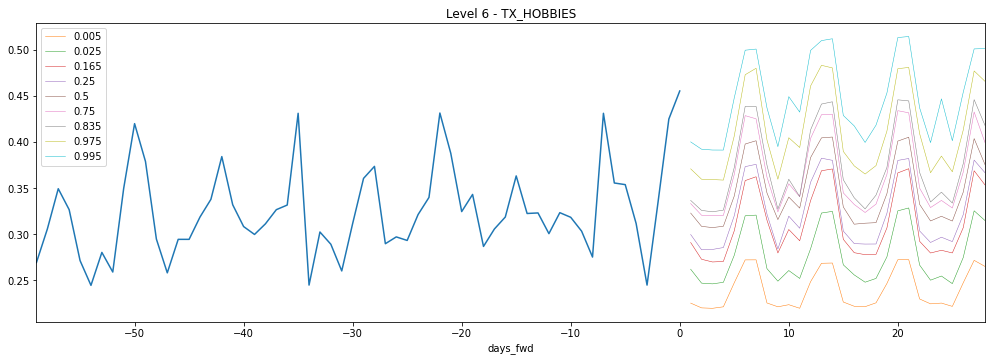

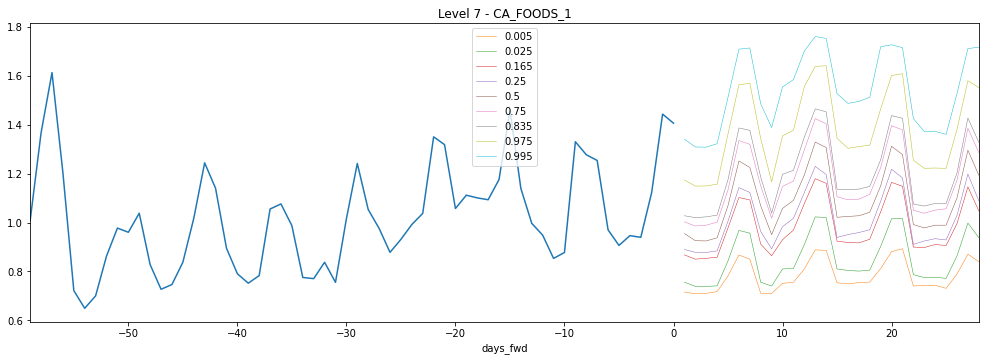

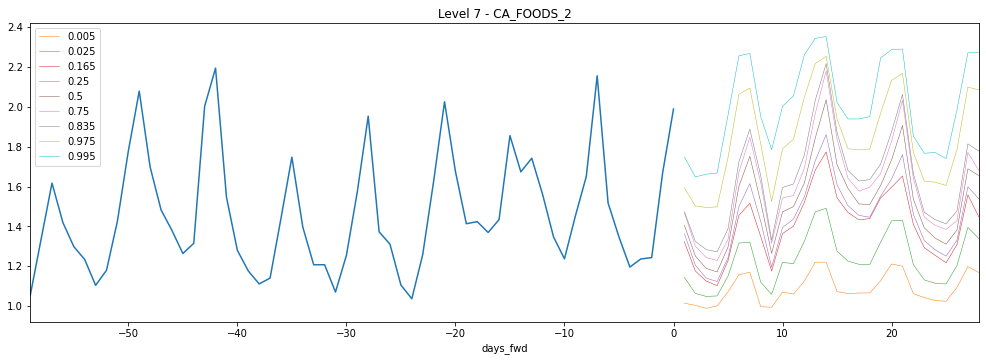

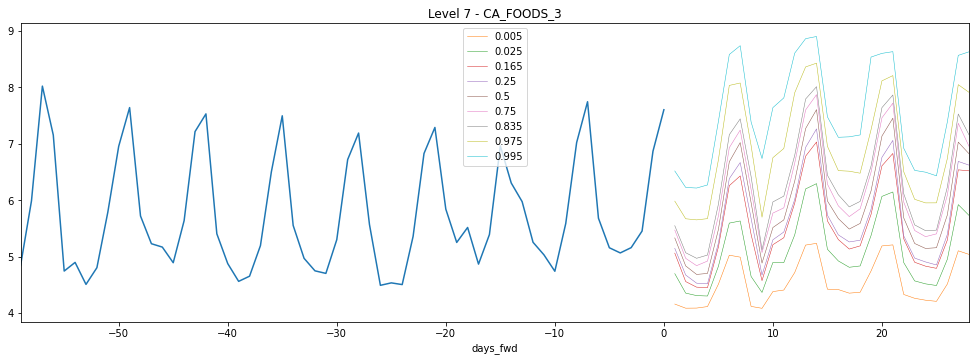

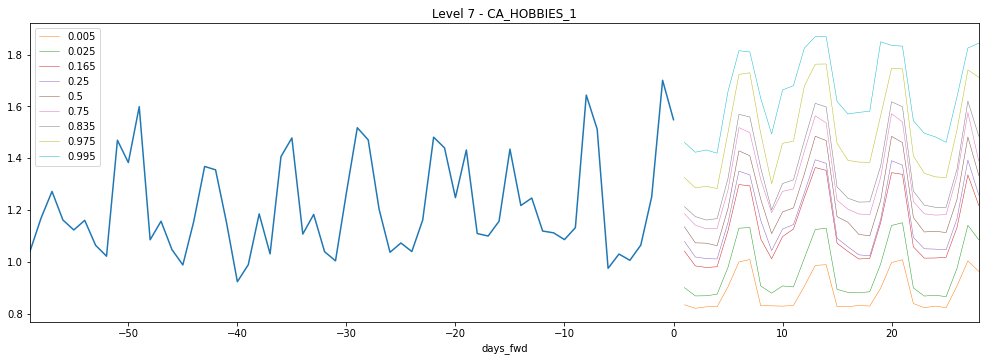

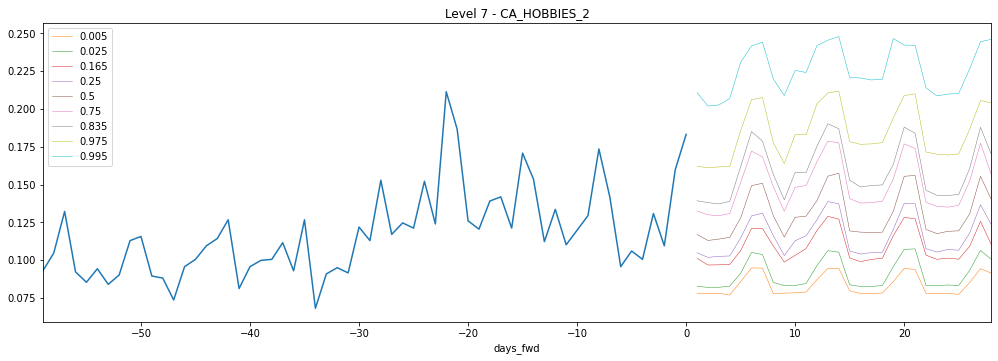

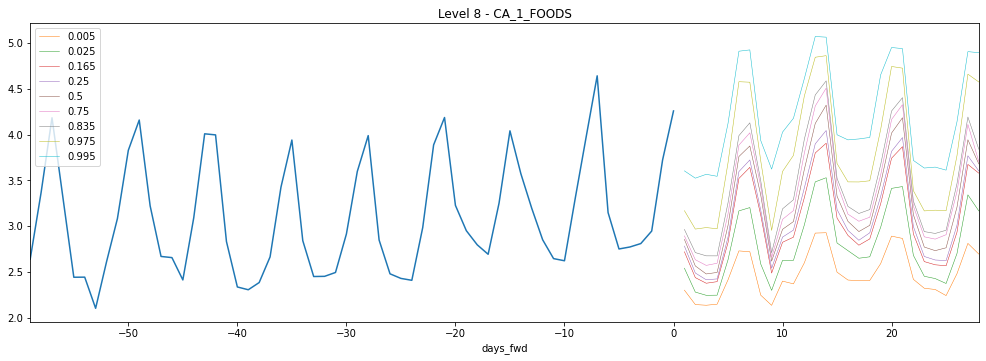

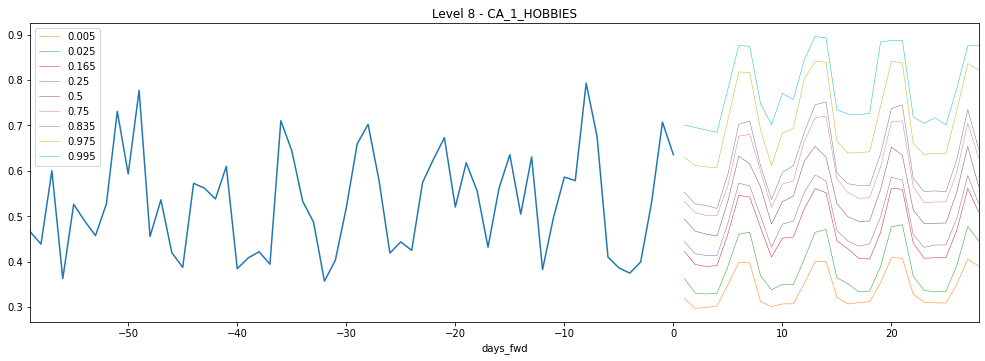

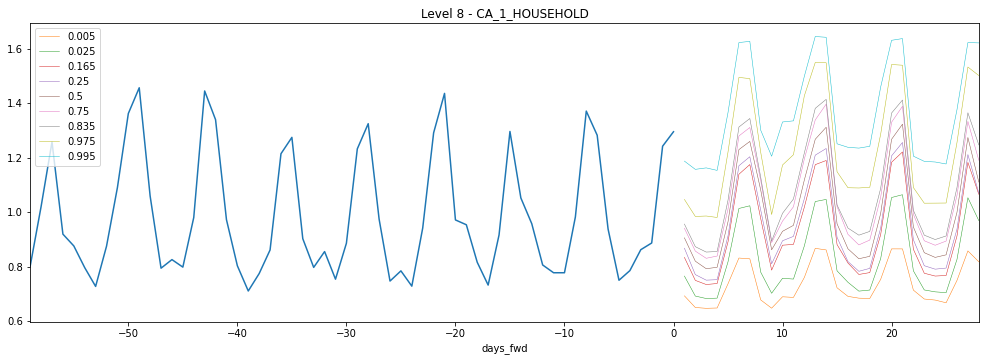

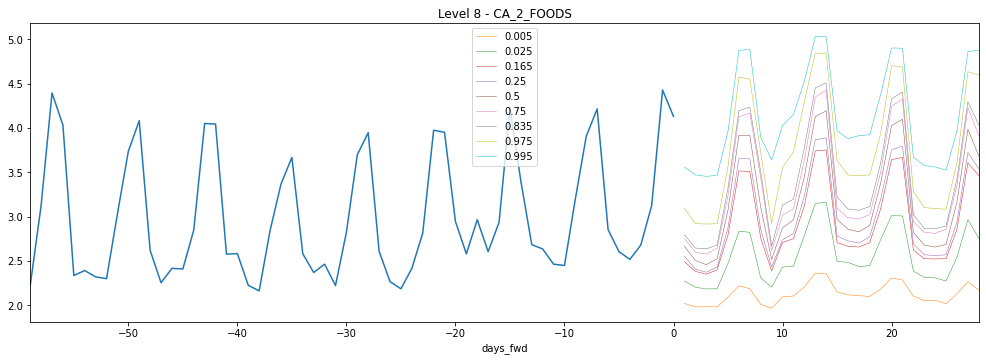

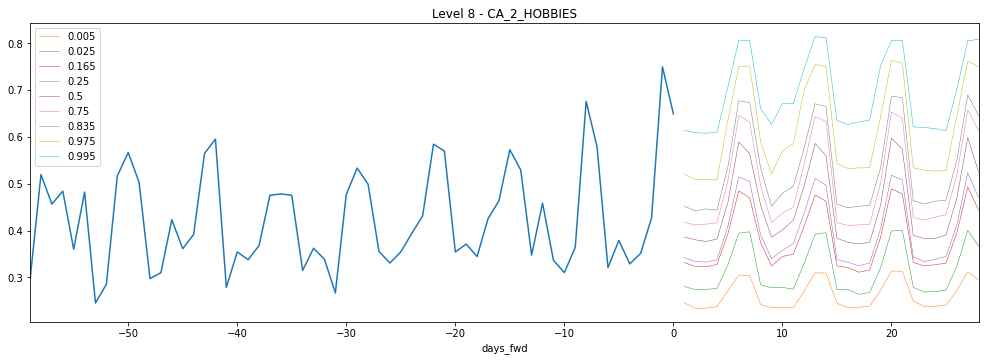

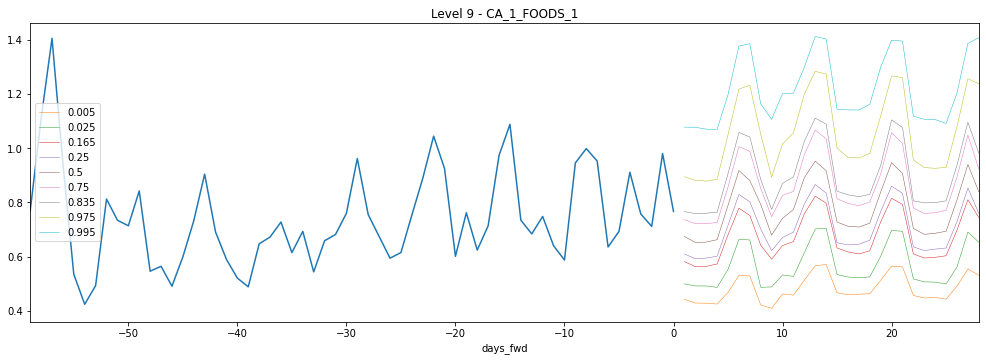

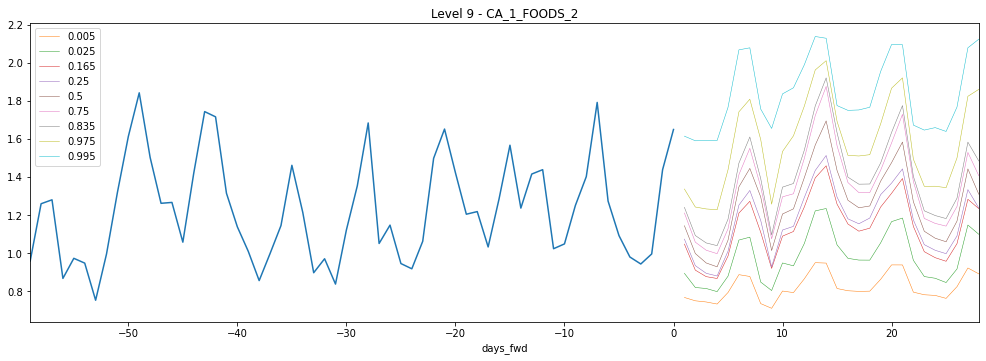

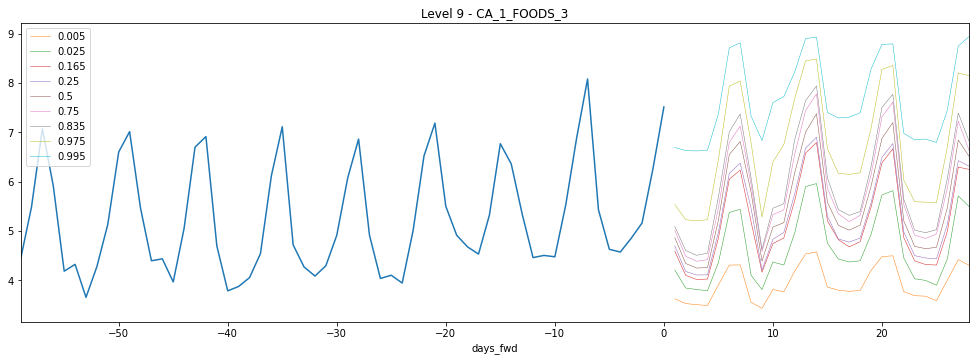

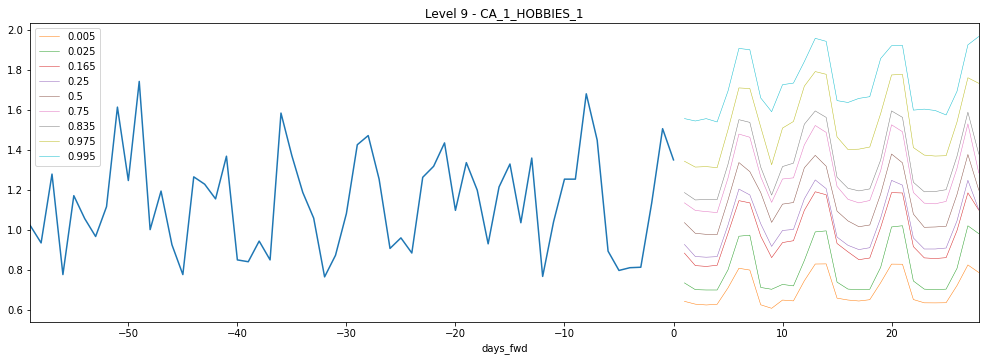

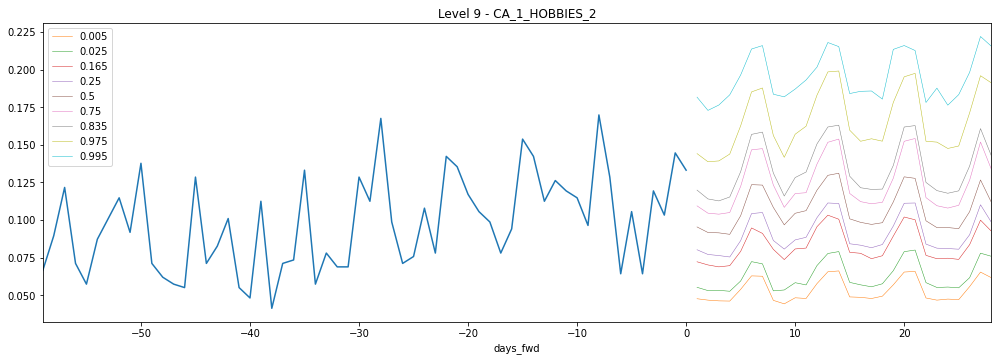

<Figure size 1224x396 with 0 Axes>

In [243]:
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    
    if level <= 9:
        series_list = predictions.series.unique()[:5]
    else:
        series_list =  series_features[( series_features.d.map(cal_index_to_day) == final_base) & 
                                         (series_features.series.map(series_id_level) == level) ]\
            .sort_values('weights', ascending = False).series.to_list()\
                 [:len(predictions.series.unique())//20 : len(predictions.series.unique()) // 500]
    
    for series in series_list:
        
        DAYS_BACK = 60
        if suffix == 'evaluation':
            prior = train_flipped.iloc[-DAYS_BACK:, series]
            prior.index = range(-DAYS_BACK + 1, 1 )
        else:
            prior = train_flipped.iloc[-DAYS_BACK:, series]
            prior.index = range(-DAYS_BACK + 28 + 1, 28 + 1 )
            
            
        f = prior.plot( linewidth = 1.5);

        f = predictions[predictions.series == series].set_index('days_fwd')\
                [[c for c in predictions.columns if c in LEVEL_QUANTILES[level]]].plot(
                                title = ("Level {} - {}".format(level, series_id_to_series[series])
                                      + ("" if level <=9 else " - weight of {:.2%}".format(
                                          predictions[predictions.series == series].weights.mean() )))
                                                       , 
                                              linewidth = 0.5, ax = f);
        f = plt.figure();
#     break;

In [244]:

# predictions

In [245]:
output_rows = []
for level in sorted(all_predictions.keys()):
    predictions = all_predictions[level]
    df = predictions[ ['series', 'days_fwd'] + list(LEVEL_QUANTILES[level])].copy()
    df.series = df.series.map(series_id_to_series)
    df = df.melt(['series', 'days_fwd'], var_name = 'q' )
    df.value = df.value / level_multiplier[level]
    df['name'] = df.series + '_' + df.q.apply(lambda x: '{0:.3f}'.format(x)) + '_' + suffix
    # df.days_fwd = 'F' + df.days_fwd.astype(str)

    for q in df.q.unique():
        qdf = df[df.q==q].pivot('name', 'days_fwd', 'value')
        qdf.columns = ['F{}'.format(c) for c in qdf.columns]
        qdf.index.name = 'id'
        output_rows.append(qdf)
    output = pd.concat(output_rows)

In [246]:
# df[::28  * 7  *10]

In [247]:
output.tail()

F1           F2           F3  \
id                                                                         
WI_3_FOODS_3_0.995_evaluation      2612.861975  2582.230043  2592.667838   
WI_3_HOBBIES_1_0.995_evaluation     379.010726   380.994515   378.014847   
WI_3_HOBBIES_2_0.995_evaluation      65.987573    66.138743    64.147848   
WI_3_HOUSEHOLD_1_0.995_evaluation   856.714898   846.535063   847.167914   
WI_3_HOUSEHOLD_2_0.995_evaluation   217.008371   217.195973   217.396374   

                                            F4           F5           F6  \
id                                                                         
WI_3_FOODS_3_0.995_evaluation      2591.515953  2879.911464  3348.782272   
WI_3_HOBBIES_1_0.995_evaluation     373.712774   407.031444   446.220970   
WI_3_HOBBIES_2_0.995_evaluation      65.471907    71.076984    75.184224   
WI_3_HOUSEHOLD_1_0.995_evaluation   849.404080   957.232804  1095.792842   
WI_3_HOUSEHOLD_2_0.995_evaluation   216.723683   236.814725   271.393957   

                                            F7           F8           F9  \
id                                                                         
WI_3_FOODS_3_0.995_evaluation      3385.467730  2856.120852  2701.928318   
WI_3_HOBBIES_1_0.995_evaluation     450.112582   395.251461   386.721412   
WI_3_HOBBIES_2_0.995_evaluation      76.968163    67.161948    67.748289   
WI_3_HOUSEHOLD_1_0.995_evaluation  1104.774683   924.282770   874.288630   
WI_3_HOUSEHOLD_2_0.995_evaluation   274.114965   234.470193   223.823508   

                                           F10  ...          F19          F20  \
id                                              ...                             
WI_3_FOODS_3_0.995_evaluation      2960.366081  ...  2960.556331  3446.073610   
WI_3_HOBBIES_1_0.995_evaluation     411.167125  ...   420.389193   457.154796   
WI_3_HOBBIES_2_0.995_evaluation      68.994689  ...    72.662151    75.039304   
WI_3_HOUSEHOLD_1_0.995_evaluation   997.725133  ...   983.300290  1117.063262   
WI_3_HOUSEHOLD_2_0.995_evaluation   250.660354  ...   242.160525   278.679592   

                                           F21          F22          F23  \
id                                                                         
WI_3_FOODS_3_0.995_evaluation      3451.831584  2749.352939  2982.857966   
WI_3_HOBBIES_1_0.995_evaluation     451.305592   385.296847   397.118135   
WI_3_HOBBIES_2_0.995_evaluation      74.775198    69.982040    69.139674   
WI_3_HOUSEHOLD_1_0.995_evaluation  1120.689957   893.930606   932.285633   
WI_3_HOUSEHOLD_2_0.995_evaluation   279.355618   224.575967   238.467497   

                                           F24          F25          F26  \
id                                                                         
WI_3_FOODS_3_0.995_evaluation      3174.451887  2660.270811  2904.210517   
WI_3_HOBBIES_1_0.995_evaluation     433.282793   383.081295   410.559119   
WI_3_HOBBIES_2_0.995_evaluation      77.127681    62.277066    69.452355   
WI_3_HOUSEHOLD_1_0.995_evaluation   983.715683   868.904562   965.157988   
WI_3_HOUSEHOLD_2_0.995_evaluation   248.875435   220.212364   238.311127   

                                           F27          F28  
id                                                           
WI_3_FOODS_3_0.995_evaluation      3353.358867  3420.621425  
WI_3_HOBBIES_1_0.995_evaluation     450.599163   458.321428  
WI_3_HOBBIES_2_0.995_evaluation      74.942615    78.530503  
WI_3_HOUSEHOLD_1_0.995_evaluation  1105.972366  1131.249878  
WI_3_HOUSEHOLD_2_0.995_evaluation   272.153685   277.203985  

[5 rows x 28 columns]

In [248]:
# train_flipped.iloc[-28:, -1]

In [249]:
# output.iloc[4, :].plot()
# (train_flipped.iloc[-28:, -1] / level_multiplier[1]).plot() 

In [250]:
sample_sub.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  F19  \
0  Total_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
1     CA_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
2     TX_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
3     WI_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
4   CA_1_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   

   F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [251]:
assert len(set(output.index) - set(sample_sub.id)) == 0

assert len(set(sample_sub.id) & set(output.index)) == len(output)

In [252]:
output.round(3).to_csv('submission.csv')

In [253]:
print(len(output) )

1386


In [254]:
# assert len(output) == len(sample_sub)

In [255]:
output

F1            F2            F3  \
id                                                                            
Total_X_0.005_evaluation           34179.984375  33120.253906  33107.066406   
Total_X_0.025_evaluation           36265.601562  34049.269531  33800.656250   
Total_X_0.165_evaluation           38287.011719  35557.496094  34892.917969   
Total_X_0.250_evaluation           38531.855469  35875.558594  35135.742188   
Total_X_0.500_evaluation           39188.617188  36405.480469  35766.207031   
...                                         ...           ...           ...   
WI_3_FOODS_3_0.995_evaluation       2612.861975   2582.230043   2592.667838   
WI_3_HOBBIES_1_0.995_evaluation      379.010726    380.994515    378.014847   
WI_3_HOBBIES_2_0.995_evaluation       65.987573     66.138743     64.147848   
WI_3_HOUSEHOLD_1_0.995_evaluation    856.714898    846.535063    847.167914   
WI_3_HOUSEHOLD_2_0.995_evaluation    217.008371    217.195973    217.396374   

                                             F4            F5            F6  \
id                                                                            
Total_X_0.005_evaluation           33184.160156  36727.871094  40160.945312   
Total_X_0.025_evaluation           33941.457031  38772.824219  44433.539062   
Total_X_0.165_evaluation           35186.171875  40352.179688  48545.691406   
Total_X_0.250_evaluation           35463.714844  40793.500000  49006.855469   
Total_X_0.500_evaluation           36048.652344  42052.519531  50282.078125   
...                                         ...           ...           ...   
WI_3_FOODS_3_0.995_evaluation       2591.515953   2879.911464   3348.782272   
WI_3_HOBBIES_1_0.995_evaluation      373.712774    407.031444    446.220970   
WI_3_HOBBIES_2_0.995_evaluation       65.471907     71.076984     75.184224   
WI_3_HOUSEHOLD_1_0.995_evaluation    849.404080    957.232804   1095.792842   
WI_3_HOUSEHOLD_2_0.995_evaluation    216.723683    236.814725    271.393957   

                                             F7            F8            F9  \
id                                                                            
Total_X_0.005_evaluation           39793.925781  33661.332031  33226.394531   
Total_X_0.025_evaluation           44359.007812  35919.296875  34330.832031   
Total_X_0.165_evaluation           48842.484375  40245.000000  36655.941406   
Total_X_0.250_evaluation           49512.078125  41984.734375  36954.062500   
Total_X_0.500_evaluation           51010.933594  43744.437500  37419.441406   
...                                         ...           ...           ...   
WI_3_FOODS_3_0.995_evaluation       3385.467730   2856.120852   2701.928318   
WI_3_HOBBIES_1_0.995_evaluation      450.112582    395.251461    386.721412   
WI_3_HOBBIES_2_0.995_evaluation       76.968163     67.161948     67.748289   
WI_3_HOUSEHOLD_1_0.995_evaluation   1104.774683    924.282770    874.288630   
WI_3_HOUSEHOLD_2_0.995_evaluation    274.114965    234.470193    223.823508   

                                            F10  ...           F19  \
id                                               ...                 
Total_X_0.005_evaluation           36979.558594  ...  39072.375000   
Total_X_0.025_evaluation           39328.574219  ...  42002.175781   
Total_X_0.165_evaluation           40955.601562  ...  44037.019531   
Total_X_0.250_evaluation           41161.042969  ...  44338.160156   
Total_X_0.500_evaluation           42158.179688  ...  45394.105469   
...                                         ...  ...           ...   
WI_3_FOODS_3_0.995_evaluation       2960.366081  ...   2960.556331   
WI_3_HOBBIES_1_0.995_evaluation      411.167125  ...    420.389193   
WI_3_HOBBIES_2_0.995_evaluation       68.994689  ...     72.662151   
WI_3_HOUSEHOLD_1_0.995_evaluation    997.725133  ...    983.300290   
WI_3_HOUSEHOLD_2_0.995_evaluation    250.660354  ...    242.160525   

                                            F20   

### Predict All and Save (Out of Date)

### Let's Examine Those Errors